In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from tabulate import tabulate

In [124]:
#Auxiliar functions

def correlation_heatmap(dfi, target="TradePrice"):
    correlation_matrix = dfi.select_dtypes(include='number').corr()
    num_vars = correlation_matrix.shape[0]
    plt.figure(figsize=(num_vars * 2, num_vars * 1.5))
    
    heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    
    # Resaltar la columna especificada como target
    if target in correlation_matrix.columns:
        # Resaltar la fila del target
        for i in range(correlation_matrix.shape[0]):
            if correlation_matrix.index[i] == target:
                heatmap.add_patch(plt.Rectangle((0, i), correlation_matrix.shape[1], 1, fill=False, edgecolor='yellow', lw=3))
            
            # Resaltar celdas donde la correlación con el target es mayor a 0.2 o menor a -0.2
            if abs(correlation_matrix.iloc[i][target]) > 0.2 and correlation_matrix.index[i] != target:
                heatmap.add_patch(plt.Rectangle((i, correlation_matrix.columns.get_loc(target)), 1, 1, fill=True, color='lightgreen', alpha=0.5))
    
    plt.title("Matriz de Correlación entre Variables Numéricas")
    plt.show()

#The code gets the number of rooms per each category and generate new column
#In case of + it counts the number of different category will me the value in FloorPlan_plus

#FloorPlan  FloorPlan_l  FloorPlan_d  FloorPlan_k  FloorPlan_s  FloorPlan_plus
#3ldk       3            1            1            0            0                 
#2ldk       2            1            1            0            0                  
#1k         0            0            1            0            0                  
#4ldk       4            1            1            0            0                  
#1ldk       1            1            1            0            0                  
                                            
#2d         0            2            0            0            0                      
#4d         0            4            0            0            0                      
#5ldk+kl    5            1            1            0            2 

#This code expects an input like this ldk+s
#Numbers can appear before + (not after)
#l, k, d, + or s can be missing but never replicated (per each side of +)
   # lk is okay
   # ll2k is wrong
   # lkd+ls is okay
   # lk+s2k is wrong (didn't find anything like this in the data)
#if nan, all columns values are 0
#next improvement is to include the processing of numbers on the right side of + 


def procesar_codigo(codigo, prefijo):
    
    # Inicializar valores con el prefijo
    num_l = 0
    num_d = 0
    num_k = 0
    num_s = 0
    num_plus = 0

    
    if not pd.isna(codigo):
        if 'l' in codigo:
            l_match = re.search(r'(\d+)l', codigo)
            if l_match:
                num_l = int(l_match.group(1))
            else:
                num_l = 1

        # Procesamos 'd'
        if 'd' in codigo:
            d_match = re.search(r'(\d+)d', codigo)
            if d_match:
                num_d = int(d_match.group(1))
            else:
                num_d = 1
    
        # Procesamos 'k'
        if 'k' in codigo:
            k_match = re.search(r'(\d+)k', codigo)
            if k_match:
                num_k = int(k_match.group(1))
            else:
                num_k = 1
    
        # Procesamos 's'
        if 's' in codigo:
            s_match = re.search(r'(\d+)s', codigo)
            if s_match:
                num_s = int(s_match.group(1))
            else:
                num_s = 1
    
        # Procesamos '+'
        if '+' in codigo:
            splits = codigo.split('+')
            if(len(splits)>1):
                plus_split = splits[1]
                plus_split = re.sub(r'\d+', "", plus_split)
                num_plus = len(plus_split)
            else:
                num_plus = 1

    return pd.Series([num_l, num_d, num_k, num_s, num_plus], 
                     index=[f'{prefijo}_l', f'{prefijo}_d', f'{prefijo}_k', f'{prefijo}_s', f'{prefijo}_plus'])
def compute_floor_plan(dfi):
    prefijo = "FloorPlan"
    tqdm.pandas()
    dfi[[f'{prefijo}_l', f'{prefijo}_d', f'{prefijo}_k', f'{prefijo}_s', f'{prefijo}_plus']] = dfi[prefijo].apply(lambda x: procesar_codigo(x, prefijo))
    return dfi
    

def check_category_in_row(row, category):
    # Verificar si la categoría está en la lista de usos
    if category in row.split(', '):
        return 1
    else:
        return 0

#This function will generate new columns in a df
#each colum is a value of column_name
#new column will be 0 or 1 
#depending if value present in column name
#               Use            Use_house  Use_housing complex  Use_shop  \
#51   factory, office                  0                    0         0   
#64   factory, office                  0                    0         0   
#1115 house, factory, office           1                    0         0   
#1511 factory                          0                    0         0   
#2788  factory, office, warehouse      0                    0         0   

#      Use_office  Use_warehouse  Use_other  Use_factory  Use_parking lot  \
#51             1              0          0            1                0   
#64             1              0          0            1                0   
#1115           1              0          0            1                0   
#1511           0              0          0            1                0   
#2788           1              1          0            1                0   
def expand_structures(dfi, column_name):
    # Rellenar los valores NaN con cadenas vacías
    dfi[column_name] = dfi[column_name].fillna('')
    
    # Expandir las estructuras usando get_dummies y sumar las ocurrencias
    structures_expanded = dfi[column_name].str.get_dummies(sep=',').sum(axis=0).sort_values(ascending=False)
    
    # Crear nuevas columnas para cada categoría
    for category in structures_expanded.index:
        # Crear una nueva columna verificando si la categoría está presente en cada fila
        dfi[f'{column_name}_{category.strip()}'] = dfi[column_name].apply(lambda x: check_category_in_row(x, category.strip()))
        
    return dfi

#TO BE DONE (idea is to do the same as the previous function but it will merge the classes that do not reach the threshold)
def expand_structures_by_rank(dfi, column_name, threshold= "True"):
    # Rellenar los valores NaN con cadenas vacías
    dfi[column_name] = dfi[column_name].fillna('')
    
    # Expandir las estructuras usando get_dummies y sumar las ocurrencias
    structures_expanded = dfi[column_name].str.get_dummies(sep=', ').sum(axis=0).sort_values(ascending=False)

    if(threshold != "True"):
        structures_expanded_grouped = structures_expanded[structures_expanded >= threshold]
        amigo_count = structures_expanded[structures_expanded < threshold].sum()
        if amigo_count > 0:
            structures_expanded_grouped['amigo'] = amigo_count
            structures_expanded = structures_expanded_grouped
        
    # Crear nuevas columnas para cada categoría
    for category in structures_expanded.index:

        # Crear una nueva columna verificando si la categoría está presente en cada fila
        dfi[f'{column_name}_{category.strip()}'] = dfi[column_name].apply(lambda x: check_category_in_row(x, category.strip()))
    return dfi

def make_dummies_analyze(dfi, column_name, target="TradePrice"):
    dummies = pd.get_dummies(dfi[column_name], prefix=column_name, drop_first=False, dtype=int)
    #print("columns dummy", dummies.columns)
    dfi = pd.concat([dfi, dummies], axis=1)
    #print("columns dfi", dfi.columns)
    to_test = [col for col in dfi.columns if column_name in col]
    #print("columns created", to_test)
    to_test.insert(0,target)
    correlation_heatmap(dfi[to_test])
    to_test.remove(target)
    check_kruskal_mannwhitneyu(dfi,to_test)
    return dfi

def drop_columns(dfi, column):
    columns_to_drop = [col for col in dfi.columns if col.startswith(column+"_")]

    # Eliminar las columnas seleccionadas
    dfi.drop(columns=columns_to_drop, inplace=True)
    return dfi

def check_kruskal_mannwhitneyu(dfi, categorical_columns, continuos_colum="TradePrice"):
    for var in categorical_columns:
        print(f'\nAnálisis para la columna: {var}')
        
        # Obtener los grupos únicos en la columna categórica actual
        groups = dfi[var].unique()
        
        # Comprobar si hay solo dos grupos para la prueba Mann-Whitney
        if len(groups) == 2:
            group1 = dfi[dfi[var] == groups[0]][continuos_colum]
            group2 = dfi[dfi[var] == groups[1]][continuos_colum]
            
            # Realizar la prueba Mann-Whitney U
            u_stat, p_value_mannwhitney = stats.mannwhitneyu(group1, group2)
            print(f'Mann-Whitney U Test:')
            print(f'U-statistic: {u_stat}, P-value: {p_value_mannwhitney}')
            
            # Visualización
            # sns.boxplot(x=var, y=continuos_colum, data=dfi)
            # plt.title(f'Comparación de precios por {var}')
            # plt.show()
        
        # Realizar la prueba Kruskal-Wallis H si hay más de dos grupos
        if len(groups) > 2:
            target_groups = []
    
            # Usar un bucle for para extraer los datos por grupo
            for group in groups:
                target = dfi[dfi[var] == group][continuos_colum]
                target_groups.append(target)
                
            h_stat, p_value_kruskal = stats.kruskal(*target_groups)
            print(f'Kruskal-Wallis H Test:')
            print(f'H-statistic: {h_stat}, P-value: {p_value_kruskal}')
        
        # Visualización
        # sns.boxplot(x=var, y=continuos_colum, data=dfi)
        # plt.title(f'Comparación de precios por {var}')
        # plt.show()

In [125]:
dataframes = []
dtypes = {
    "Type": "str",
    "Region": "str",
    "Prefecture": "str",
    "MunicipalityCode": "str",
    "Municipality": "str",
    "DistrictName": "str",
    "NearestStation": "str",
    "TimeToNearestStation": "str",
    "FloorPlan": "str",
    "LandShape": "str",
    "Structure": "str",
    "Use": "str",
    "Purpose": "str",
    "Direction": "str",
    "Classification": "str",
    "CityPlanning": "str",
    "Period": "str",
    "Renovation": "str",
    "Remarks": "str",
    # Añadiendo las columnas booleanas
    "AreaIsGreaterFlag": bool,
    "FrontageIsGreaterFlag": bool,
    "TotalFloorAreaIsGreaterFlag": bool,
    "PrewarBuilding": bool
}
# Bucle para leer cada archivo CSV
for i in range(1, 48):  # Del 01 al 47
    # Formatear el número con ceros a la izquierda
    filename = f"trade_prices/{i:02}.csv"
    
    # Leer el archivo y agregarlo a la lista
    df = pd.read_csv(filename, dtype=dtypes)
    dataframes.append(df)

# Concatenar todos los DataFrames en uno solo
combined_df = pd.concat(dataframes, ignore_index=True)

# Verificar las primeras filas del DataFrame combinado
print(combined_df.head())

   No                          Type            Region MunicipalityCode  \
0   1   Residential Land(Land Only)  Residential Area             1101   
1   2   Residential Land(Land Only)  Residential Area             1101   
2   3  Pre-owned Condominiums, etc.               NaN             1101   
3   4   Residential Land(Land Only)  Residential Area             1101   
4   5   Residential Land(Land Only)  Residential Area             1101   

  Prefecture            Municipality DistrictName NearestStation  \
0   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
1   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
2   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
3   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   
4   Hokkaido  Chuo Ward,Sapporo City   Asahigaoka   Maruyamakoen   

  TimeToNearestStation  MinTimeToNearestStation  ...  Classification  Breadth  \
0                   28                     28.0  ...       City R

In [126]:
df = combined_df

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3906518 entries, 0 to 3906517
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   No                           int64  
 1   Type                         object 
 2   Region                       object 
 3   MunicipalityCode             object 
 4   Prefecture                   object 
 5   Municipality                 object 
 6   DistrictName                 object 
 7   NearestStation               object 
 8   TimeToNearestStation         object 
 9   MinTimeToNearestStation      float64
 10  MaxTimeToNearestStation      float64
 11  TradePrice                   int64  
 12  FloorPlan                    object 
 13  Area                         int64  
 14  AreaIsGreaterFlag            bool   
 15  UnitPrice                    float64
 16  PricePerTsubo                float64
 17  LandShape                    object 
 18  Frontage                     float64
 19  

In [128]:
df.describe()

No  MinTimeToNearestStation  MaxTimeToNearestStation  \
count  3.906518e+06             3.315977e+06             3.228071e+06   
mean   7.835413e+04             2.258420e+01             2.738394e+01   
std    8.017355e+04             2.308245e+01             2.773212e+01   
min    1.000000e+00             0.000000e+00             0.000000e+00   
25%    2.078000e+04             9.000000e+00             8.000000e+00   
50%    4.815900e+04             1.600000e+01             1.500000e+01   
75%    1.147330e+05             3.000000e+01             2.900000e+01   
max    4.065750e+05             1.200000e+02             1.200000e+02   

         TradePrice          Area     UnitPrice  PricePerTsubo      Frontage  \
count  3.906518e+06  3.906518e+06  1.384415e+06   1.384415e+06  2.537063e+06   
mean   2.760589e+07  4.674023e+02  8.514886e+04   2.814065e+05  1.463955e+01   
std    1.417460e+08  8.476877e+02  1.686832e+05   5.570316e+05  9.828225e+00   
min    1.000000e+02  1.000000e+01  1.000000e+00   2.000000e+00  1.000000e-01   
25%    5.000000e+06  1.000000e+02  1.600000e+04   5.500000e+04  8.500000e+00   
50%    1.400000e+07  1.850000e+02  4.000000e+04   1.300000e+05  1.200000e+01   
75%    2.900000e+07  3.700000e+02  9.100000e+04   3.000000e+05  1.700000e+01   
max    6.100000e+10  5.000000e+03  2.000000e+07   6.600000e+07  5.000000e+01   

       TotalFloorArea  BuildingYear       Breadth  CoverageRatio  \
count    1.317660e+06  1.869804e+06  2.685837e+06   3.191877e+06   
mean     1.751561e+02  1.995469e+03  6.792815e+00   6.101047e+01   
std      2.564390e+02  1.522054e+01  4.634588e+00   1.002819e+01   
min      1.000000e+01  1.945000e+03  1.000000e+00   3.000000e+01   
25%      9.500000e+01  1.984000e+03  4.000000e+00   6.000000e+01   
50%      1.050000e+02  1.996000e+03  6.000000e+00   6.000000e+01   
75%      1.400000e+02  2.009000e+03  7.000000e+00   6.000000e+01   
max      2.000000e+03  2.020000e+03  9.990000e+01   8.000000e+01   

       FloorAreaRatio          Year       Quarter  
count    3.191877e+06  3.906518e+06  3.906518e+06  
mean     2.089891e+02  2.012866e+03  2.519816e+00  
std      1.075456e+02  3.678827e+00  1.118905e+00  
min      5.000000e+01  2.005000e+03  1.000000e+00  
25%      2.000000e+02  2.010000e+03  2.000000e+00  
50%      2.000000e+02  2.013000e+03  3.000000e+00  
75%      2.000000e+02  2.016000e+03  4.000000e+00  
max      1.300000e+03  2.019000e+03  4.000000e+00

In [130]:
df = df.sort_values(by=['Year', 'Quarter'])
df = df.reset_index(drop=True)
df.head()

No                                 Type                      Region  \
0   6770          Residential Land(Land Only)            Residential Area   
1  22975  Residential Land(Land and Building)            Residential Area   
2  58827  Residential Land(Land and Building)            Residential Area   
3  65258  Residential Land(Land and Building)            Residential Area   
4  41007          Residential Land(Land Only)  Potential Residential Area   

  MunicipalityCode         Prefecture                 Municipality  \
0             1101           Hokkaido       Chuo Ward,Sapporo City   
1             1102           Hokkaido       Kita Ward,Sapporo City   
2             1107           Hokkaido      Nishi Ward,Sapporo City   
3             1108           Hokkaido  Atsubetsu Ward,Sapporo City   
4             4105  Miyagi Prefecture       Izumi Ward,Sendai City   

          DistrictName          NearestStation TimeToNearestStation  \
0       Minami8jonishi          Nishi 18-chome                   15   
1            Tonden8jo                     NaN                  NaN   
2     Hachiken9jonishi     Shinkawa (Hokkaido)                   16   
3  Atsubetsuhigashi5jo  Shinrinkoen (Hokkaido)                    5   
4              Fukuoka               Izumichuo                  2H-   

   MinTimeToNearestStation  ...  Classification  Breadth  \
0                     15.0  ...       City Road      7.2   
1                      NaN  ...             NaN      NaN   
2                     16.0  ...       City Road      8.0   
3                      5.0  ...       City Road      8.0   
4                    120.0  ...             NaN      NaN   

                                        CityPlanning  CoverageRatio  \
0                       Neighborhood Commercial Zone           80.0   
1                                                NaN            NaN   
2  Category II Exclusively Medium-high Residentia...           60.0   
3  Category II Exclusively Medium-high Residentia...           60.0   
4                         Outside City Planning Area            NaN   

   FloorAreaRatio            Period  Year Quarter  Renovation  Remarks  
0           300.0  3rd quarter 2005  2005       3         NaN      NaN  
1             NaN  3rd quarter 2005  2005       3         NaN      NaN  
2           200.0  3rd quarter 2005  2005       3         NaN      NaN  
3           200.0  3rd quarter 2005  2005       3         NaN      NaN  
4             NaN  3rd quarter 2005  2005       3         NaN      NaN  

[5 rows x 38 columns]

In [131]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip().str.lower()

In [132]:
mask = df["TradePrice"].isnull()

In [133]:
df[mask]

Empty DataFrame
Columns: [No, Type, Region, MunicipalityCode, Prefecture, Municipality, DistrictName, NearestStation, TimeToNearestStation, MinTimeToNearestStation, MaxTimeToNearestStation, TradePrice, FloorPlan, Area, AreaIsGreaterFlag, UnitPrice, PricePerTsubo, LandShape, Frontage, FrontageIsGreaterFlag, TotalFloorArea, TotalFloorAreaIsGreaterFlag, BuildingYear, PrewarBuilding, Structure, Use, Purpose, Direction, Classification, Breadth, CityPlanning, CoverageRatio, FloorAreaRatio, Period, Year, Quarter, Renovation, Remarks]
Index: []

[0 rows x 38 columns]

In [134]:
# no hay elementos que no tengan precio

# ADA

## Are there any duplicates?

In the beginning, it seems that there are no duplicates, but there is the "No" column that represents the number of transactions and it was not consdered. If we delete it, we will see that there are duplicates. It means that there was an error when collecting data or the same building was sold more than once in the same quarter.

In [135]:
num_duplicados = df.duplicated().sum()
print("Número de filas duplicadas:", num_duplicados)

Número de filas duplicadas: 0


In [136]:
mask = df.duplicated(subset=df.columns.difference(['No']))

In [137]:
print("Número de filas duplicadas:", mask.sum())

Número de filas duplicadas: 19447


In [138]:
filas_duplicadas = df[mask]

In [139]:
filas_duplicadas.head()

No                          Type Region MunicipalityCode  \
428  43854  pre-owned condominiums, etc.    NaN            11108   
429  43856  pre-owned condominiums, etc.    NaN            11108   
431  43861  pre-owned condominiums, etc.    NaN            11108   
432  43863  pre-owned condominiums, etc.    NaN            11108   
433  43865  pre-owned condominiums, etc.    NaN            11108   

             Prefecture              Municipality    DistrictName  \
428  saitama prefecture  minami ward,saitama city  oaza daitakubo   
429  saitama prefecture  minami ward,saitama city  oaza daitakubo   
431  saitama prefecture  minami ward,saitama city  oaza daitakubo   
432  saitama prefecture  minami ward,saitama city  oaza daitakubo   
433  saitama prefecture  minami ward,saitama city  oaza daitakubo   

    NearestStation TimeToNearestStation  MinTimeToNearestStation  ...  \
428    minamiurawa                  NaN                      NaN  ...   
429    minamiurawa                  NaN                      NaN  ...   
431    minamiurawa                  NaN                      NaN  ...   
432    minamiurawa                  NaN                      NaN  ...   
433    minamiurawa                  NaN                      NaN  ...   

     Classification  Breadth CityPlanning  CoverageRatio  FloorAreaRatio  \
428             NaN      NaN          NaN            NaN             NaN   
429             NaN      NaN          NaN            NaN             NaN   
431             NaN      NaN          NaN            NaN             NaN   
432             NaN      NaN          NaN            NaN             NaN   
433             NaN      NaN          NaN            NaN             NaN   

               Period  Year Quarter  Renovation  Remarks  
428  3rd quarter 2005  2005       3     not yet      NaN  
429  3rd quarter 2005  2005       3     not yet      NaN  
431  3rd quarter 2005  2005       3     not yet      NaN  
432  3rd quarter 2005  2005       3     not yet      NaN  
433  3rd quarter 2005  2005       3     not yet      NaN  

[5 rows x 38 columns]

In [140]:
df = df.drop_duplicates(subset=df.columns.difference(['No']))

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3887071 entries, 0 to 3906517
Data columns (total 38 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   No                           int64  
 1   Type                         object 
 2   Region                       object 
 3   MunicipalityCode             object 
 4   Prefecture                   object 
 5   Municipality                 object 
 6   DistrictName                 object 
 7   NearestStation               object 
 8   TimeToNearestStation         object 
 9   MinTimeToNearestStation      float64
 10  MaxTimeToNearestStation      float64
 11  TradePrice                   int64  
 12  FloorPlan                    object 
 13  Area                         int64  
 14  AreaIsGreaterFlag            bool   
 15  UnitPrice                    float64
 16  PricePerTsubo                float64
 17  LandShape                    object 
 18  Frontage                     float64
 19  Front

The lines duplicaded is done but the data on the df seems redundant, for example, Municipality and MunicipalityCode. Deep analisys is done in the section.

In [142]:
#Columns to delete
to_delete = []
to_delete.append("No")


## Delete data redundancy

In [143]:
df.columns

Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks'],
      dtype='object')

 Redundancy groups
- group 1:  #TimeToNearestStation       MinTimeToNearestStation      MaxTimeToNearestStation
- group 2: 'Period', 'Year',  'Quarter'
- group 3: PricePerTsubo, UnitPrice
- group 4: Municipality MunicipalityCode

Group 1
Documentation mention that MinTimeToNearestStation      MaxTimeToNearestStation were created based on TimeToNearestStation,
Therefore TimeToNearestStation will be deleted, besides it includes a mix of numeric and string date.

In [144]:
#TimeToNearestStation       MinTimeToNearestStation      MaxTimeToNearestStation       
to_delete.append("TimeToNearestStation")

In [145]:
son_iguales = (df['MaxTimeToNearestStation'].astype(np.float64) == df['MinTimeToNearestStation'].astype(np.float64)) 

In [146]:
son_iguales.sum()

2417072

In [147]:
df.shape[0]

3887071

In [148]:
df['MaxTimeToNearestStation'].isnull().sum()

669855

In [149]:
df['MinTimeToNearestStation'].isnull().sum()

582079

In [150]:
# si no hay tiempo max en los datos, significa que el max time es igual al min time y viceversa
df['MaxTimeToNearestStation'] = df['MaxTimeToNearestStation'].fillna(df['MinTimeToNearestStation'])
df['MinTimeToNearestStation'] = df['MinTimeToNearestStation'].fillna(df['MaxTimeToNearestStation'])

In [151]:
df['MaxTimeToNearestStation'].isnull().sum()

582079

In [152]:
df['MinTimeToNearestStation'].isnull().sum()

582079

Group 2
Period, Year and Quarter columns contain redundant data

In [153]:
df[['Period',"Year","Quarter"]].head()

Period  Year  Quarter
0  3rd quarter 2005  2005        3
1  3rd quarter 2005  2005        3
2  3rd quarter 2005  2005        3
3  3rd quarter 2005  2005        3
4  3rd quarter 2005  2005        3

In [154]:
df[['Period',"Year","Quarter"]].isnull().sum()

Period     0
Year       0
Quarter    0
dtype: int64

In [155]:
#add Period to_delete array
to_delete.append("Period")

Group 3: PricePerTsubo and UnitPrice

They are the same but in different measures

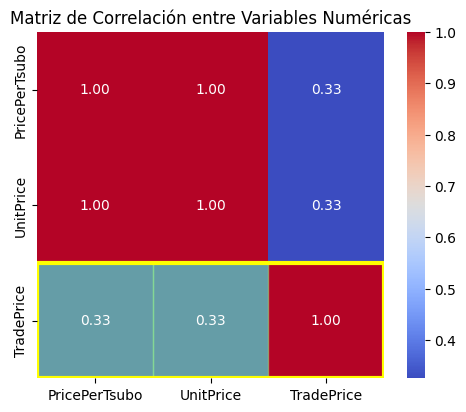

In [156]:
correlation_heatmap(df[['PricePerTsubo',"UnitPrice","TradePrice"]])

In [157]:
to_delete.append("PricePerTsubo")

Group 4: Municipality and MunicipalityCode

Municipality will be deleted but not yet as it will be analize later on following notebook

In [158]:
#to_delete.append("Municipality")

# EDA - FASE 2

This section will analize categorical and numeric values to gather relevant information for building a model. First numeric data will be analized and then categorical one. Categorical seems challenginf due to large amount of NaN values.

Lets have a look at numeric columns

In [159]:
df_number = df.select_dtypes(include='number')


In [160]:
print("numeric Variables: ", df_number.columns)

numeric Variables:  Index(['No', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
       'TradePrice', 'Area', 'UnitPrice', 'PricePerTsubo', 'Frontage',
       'TotalFloorArea', 'BuildingYear', 'Breadth', 'CoverageRatio',
       'FloorAreaRatio', 'Year', 'Quarter'],
      dtype='object')


In [161]:
df_number.describe()

No  MinTimeToNearestStation  MaxTimeToNearestStation  \
count  3.887071e+06             3.304992e+06             3.304992e+06   
mean   7.833219e+04             2.260733e+01             2.987038e+01   
std    8.016223e+04             2.309134e+01             3.115386e+01   
min    1.000000e+00             0.000000e+00             0.000000e+00   
25%    2.076800e+04             9.000000e+00             9.000000e+00   
50%    4.813500e+04             1.600000e+01             1.600000e+01   
75%    1.147005e+05             3.000000e+01             6.000000e+01   
max    4.065750e+05             1.200000e+02             1.200000e+02   

         TradePrice          Area     UnitPrice  PricePerTsubo      Frontage  \
count  3.887071e+06  3.887071e+06  1.380974e+06   1.380974e+06  2.533190e+06   
mean   2.767174e+07  4.654612e+02  8.520552e+04   2.815937e+05  1.464247e+01   
std    1.420790e+08  8.433229e+02  1.686904e+05   5.570592e+05  9.830680e+00   
min    1.000000e+02  1.000000e+01  1.000000e+00   2.000000e+00  1.000000e-01   
25%    5.000000e+06  1.000000e+02  1.700000e+04   5.500000e+04  8.500000e+00   
50%    1.400000e+07  1.850000e+02  4.000000e+04   1.300000e+05  1.200000e+01   
75%    2.900000e+07  3.700000e+02  9.100000e+04   3.000000e+05  1.700000e+01   
max    6.100000e+10  5.000000e+03  2.000000e+07   6.600000e+07  5.000000e+01   

       TotalFloorArea  BuildingYear       Breadth  CoverageRatio  \
count    1.316791e+06  1.861700e+06  2.681785e+06   3.180725e+06   
mean     1.751766e+02  1.995430e+03  6.792255e+00   6.098872e+01   
std      2.564560e+02  1.522598e+01  4.634780e+00   1.001410e+01   
min      1.000000e+01  1.945000e+03  1.000000e+00   3.000000e+01   
25%      9.500000e+01  1.984000e+03  4.000000e+00   6.000000e+01   
50%      1.050000e+02  1.996000e+03  6.000000e+00   6.000000e+01   
75%      1.400000e+02  2.009000e+03  7.000000e+00   6.000000e+01   
max      2.000000e+03  2.020000e+03  9.990000e+01   8.000000e+01   

       FloorAreaRatio          Year       Quarter  
count    3.180725e+06  3.887071e+06  3.887071e+06  
mean     2.086396e+02  2.012870e+03  2.519678e+00  
std      1.071096e+02  3.678005e+00  1.118740e+00  
min      5.000000e+01  2.005000e+03  1.000000e+00  
25%      2.000000e+02  2.010000e+03  2.000000e+00  
50%      2.000000e+02  2.013000e+03  3.000000e+00  
75%      2.000000e+02  2.016000e+03  4.000000e+00  
max      1.300000e+03  2.019000e+03  4.000000e+00

In [162]:
#There is no negative values, time, area, price cannot be negative.
#Lets check NaN values

In [163]:
df_number.isnull().sum()

No                               0
MinTimeToNearestStation     582079
MaxTimeToNearestStation     582079
TradePrice                       0
Area                             0
UnitPrice                  2506097
PricePerTsubo              2506097
Frontage                   1353881
TotalFloorArea             2570280
BuildingYear               2025371
Breadth                    1205286
CoverageRatio               706346
FloorAreaRatio              706346
Year                             0
Quarter                          0
dtype: int64

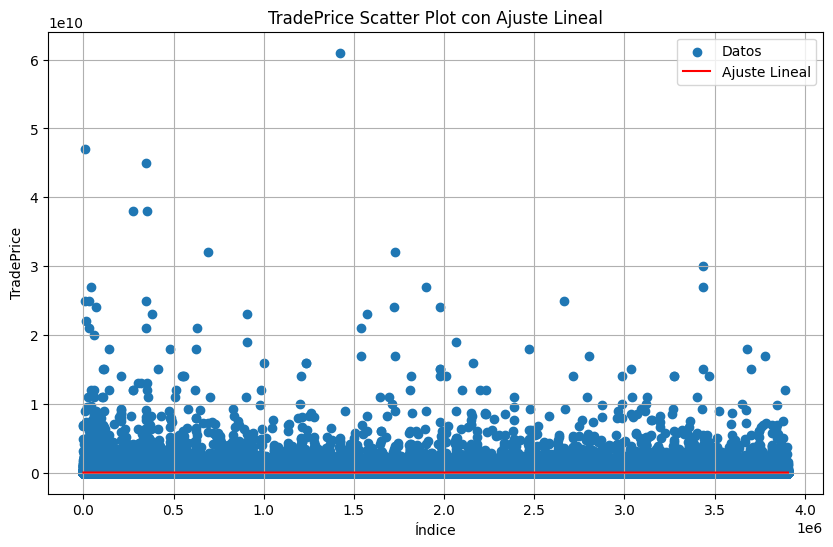

In [170]:
df_number = df_number.sort_index()
plt.figure(figsize=(10, 6))
plt.scatter(df_number.index, df_number['TradePrice'], marker='o', label='Datos')

# Ajustar una línea
z = np.polyfit(df_number.index, df_number['TradePrice'], 1)  # Ajuste lineal
p = np.poly1d(z)
plt.plot(df_number.index, p(df_number.index), color='red', label='Ajuste Lineal')

plt.title('TradePrice Scatter Plot con Ajuste Lineal')
plt.xlabel('Índice')
plt.ylabel('TradePrice')
plt.grid()
plt.legend()
plt.show()

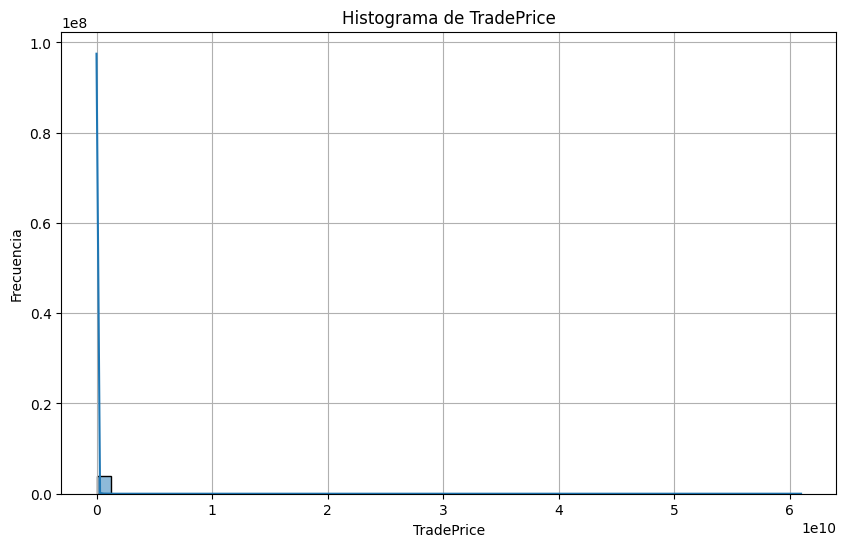

In [174]:
plt.figure(figsize=(10, 6))
sns.histplot(df_number['TradePrice'], bins=50, kde=True)  # 'kde=True' añade una línea de densidad
plt.title('Histograma de TradePrice')
plt.xlabel('TradePrice')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

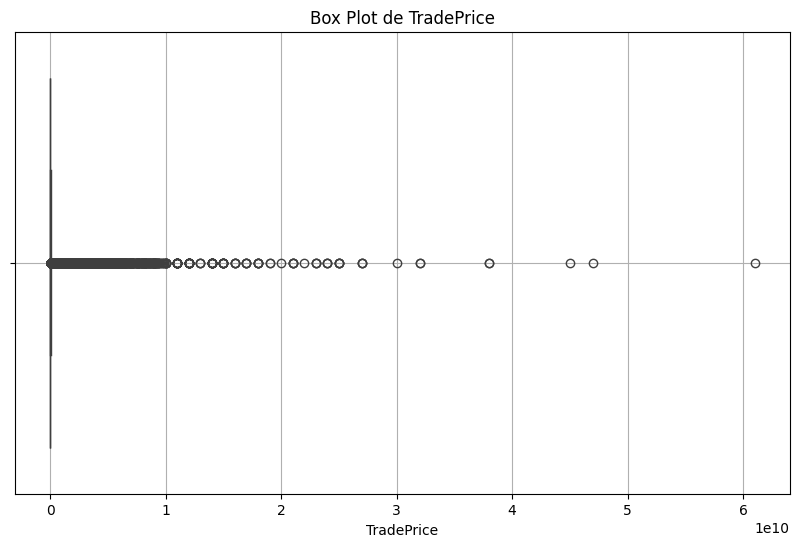

In [173]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_number['TradePrice'])
plt.title('Box Plot de TradePrice')
plt.xlabel('TradePrice')
plt.grid()
plt.show()

In [172]:
df_number["TradePrice"].describe()
#min is 100, max is 61 000 Millons and STD is 142 millos. There is a big fluctuation of data

count    3.887071e+06
mean     2.767174e+07
std      1.420790e+08
min      1.000000e+02
25%      5.000000e+06
50%      1.400000e+07
75%      2.900000e+07
max      6.100000e+10
Name: TradePrice, dtype: float64

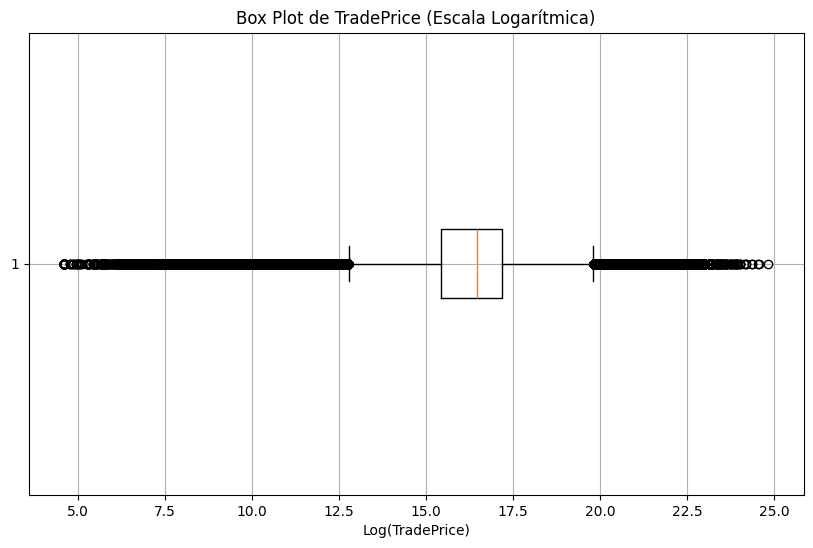

In [171]:
#There are big fluctuations of the data. Let´s try to cumpute a better plot
plt.figure(figsize=(10, 6))
plt.boxplot(np.log(df_number['TradePrice']), vert=False)
plt.title('Box Plot de TradePrice (Escala Logarítmica)')
plt.xlabel('Log(TradePrice)')
plt.grid()
plt.show()

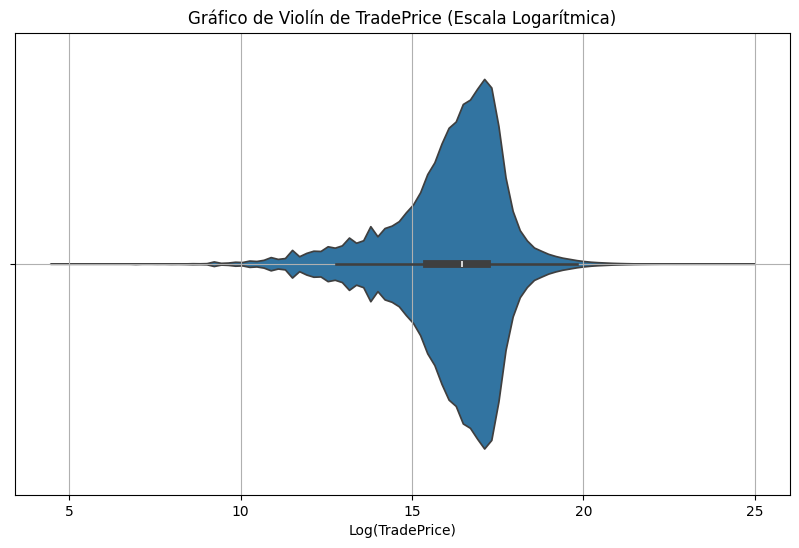

In [176]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=np.log(df_number['TradePrice']))
plt.title('Gráfico de Violín de TradePrice (Escala Logarítmica)')
plt.xlabel('Log(TradePrice)')
plt.grid()
plt.show()

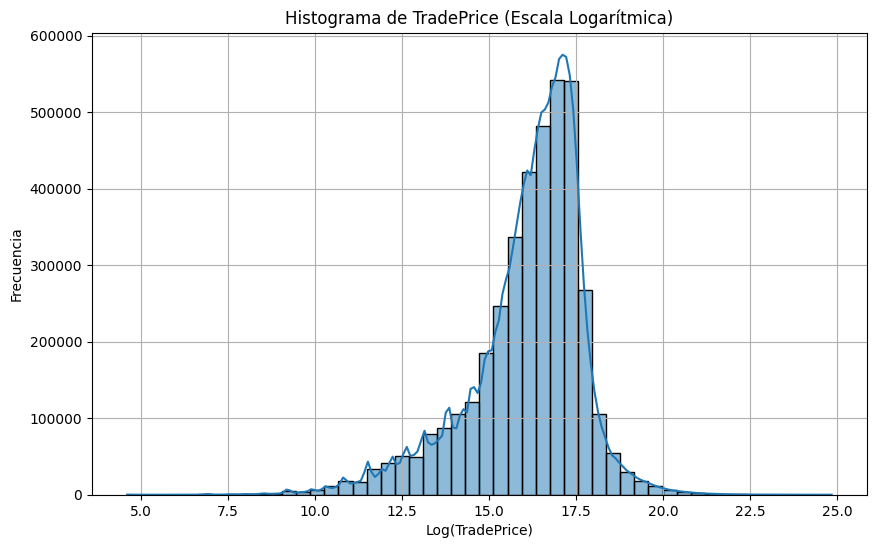

In [178]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(df_number['TradePrice']), bins=50, kde=True)  # 'kde=True' añade una línea de densidad
plt.title('Histograma de TradePrice (Escala Logarítmica)')
plt.xlabel('Log(TradePrice)')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

One thing that could be done to avoid such a big distribution is to apply transformation on TradePrice. The model predictions should be applied the reversed functions to get the real TradePrice.

Unfortunately I didnt have time to test it.

In [188]:
df_number.columns

Index(['No', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
       'TradePrice', 'Area', 'UnitPrice', 'PricePerTsubo', 'Frontage',
       'TotalFloorArea', 'BuildingYear', 'Breadth', 'CoverageRatio',
       'FloorAreaRatio', 'Year', 'Quarter'],
      dtype='object')

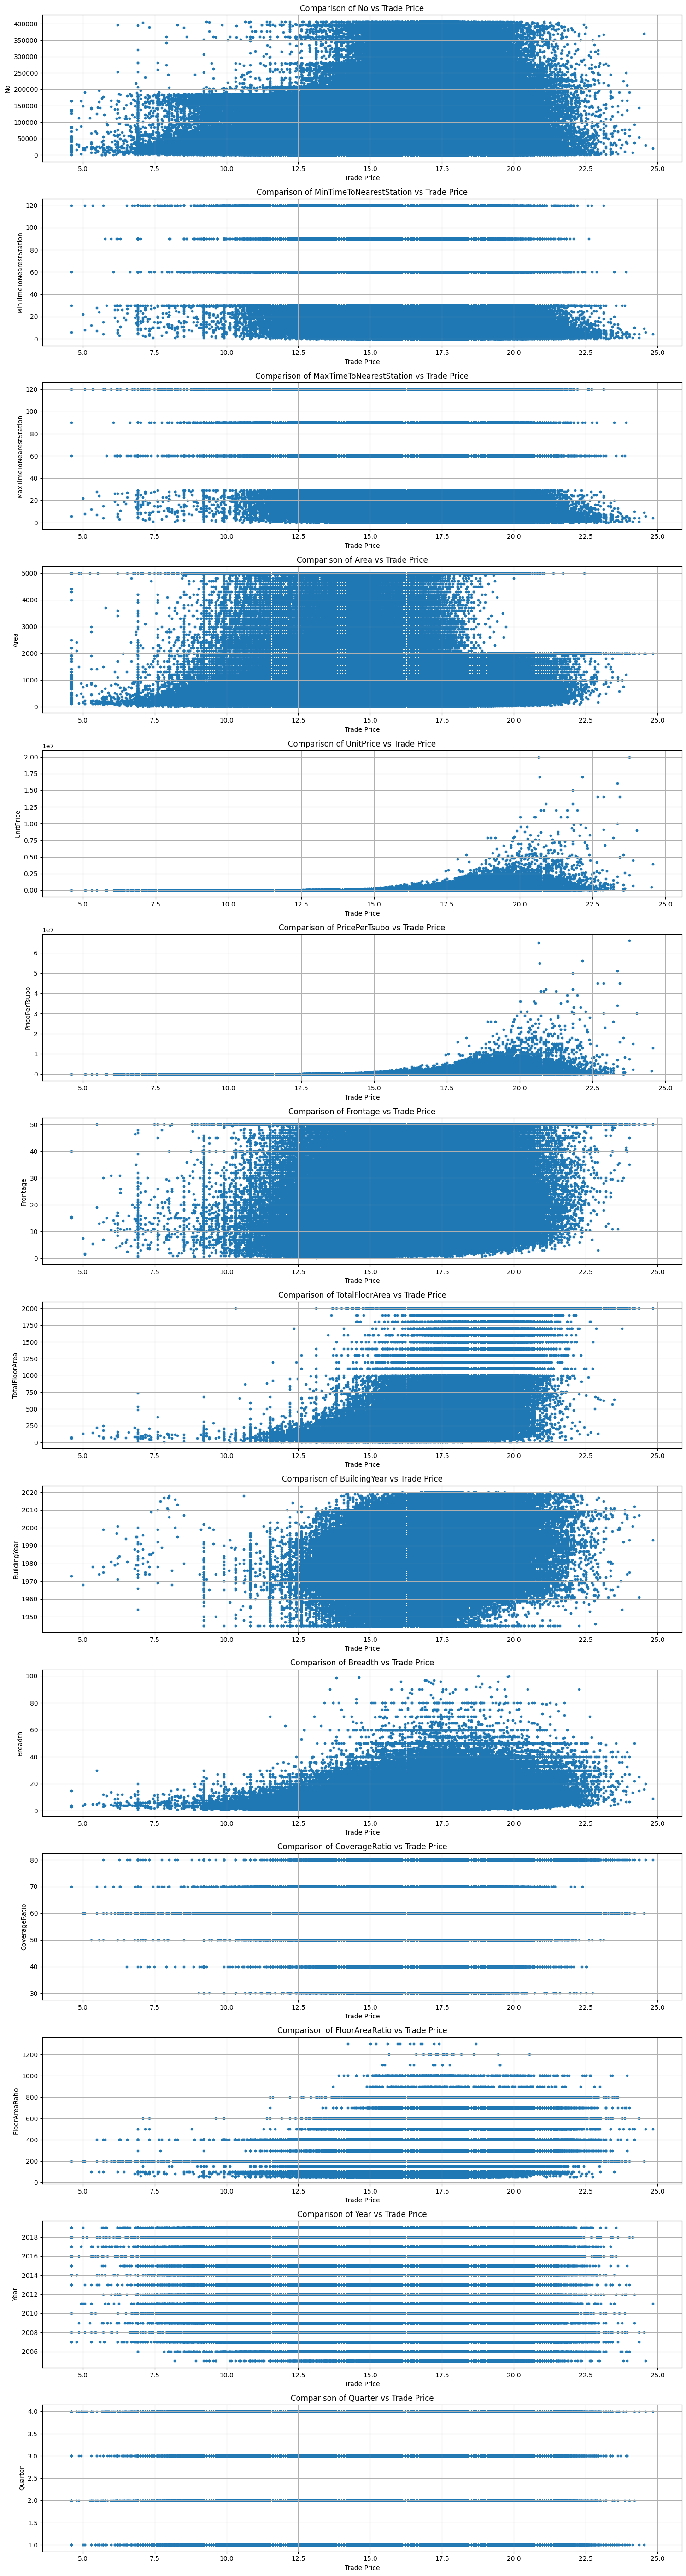

TypeError: DataFrame.drop() got an unexpected keyword argument 'inplece'

In [189]:
columns_to_plot = [col for col in df_number.columns if col != 'TradePrice']
df_number['LogTradePrice'] = np.log(df_number['TradePrice'])
num_cols = len(columns_to_plot)
fig, axs = plt.subplots(num_cols, 1, figsize=(15, num_cols * 4))

for i, col in enumerate(columns_to_plot):
    scatter = axs[i].scatter(df_number['LogTradePrice'], df_number[col], s=10) 
    axs[i].set_title(f'Comparison of {col} vs Trade Price')
    axs[i].set_xlabel('Trade Price')  # Etiqueta del eje x
    axs[i].set_ylabel(col)  # Etiqueta del eje y
    axs[i].grid(True)

plt.subplots_adjust(hspace=0.5)  # Ajustar el espacio entre subgráficas
plt.tight_layout()  
plt.show()
df_number.drop("LogTradePrice", inplece=True,axis=1)

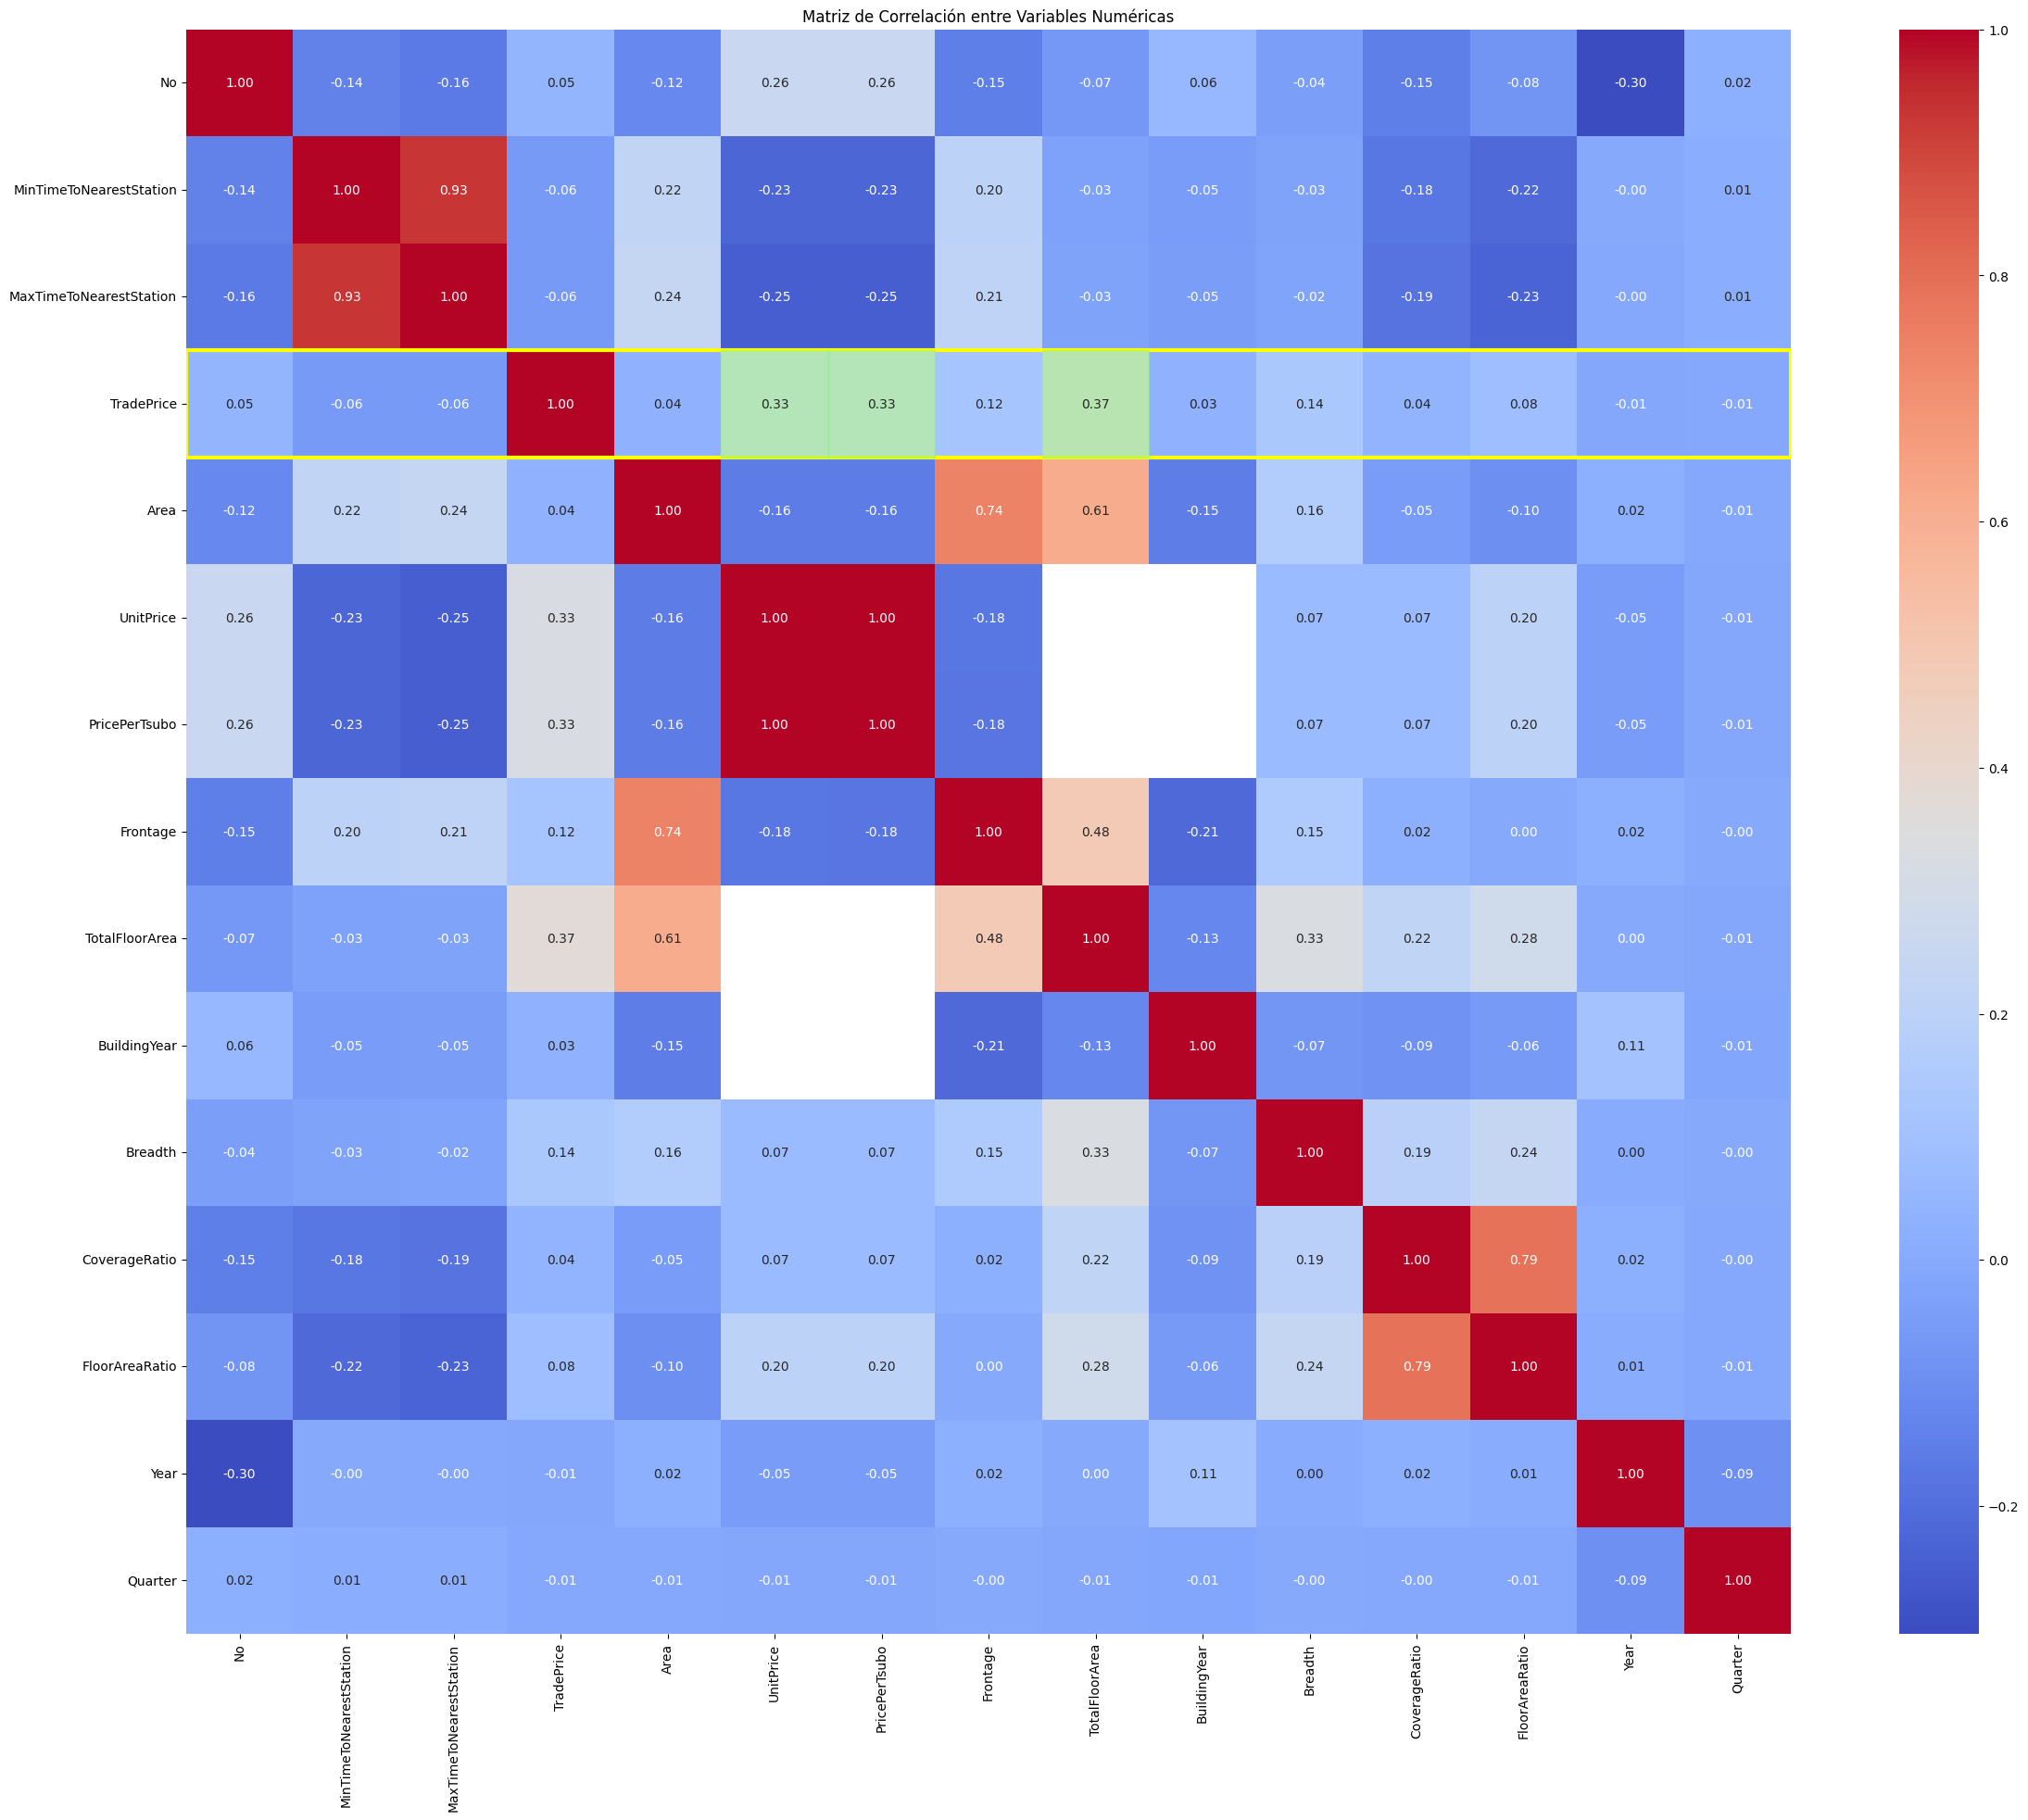

In [42]:
correlation_heatmap(df_number.copy())

The data does not correlate. it show that year and quarter doesnt afect the price (at least not lineary).


Remove NaN values in BuildingYear, Mean if NaN else 1944 (one year before war)

In [43]:
df["PrewarBuilding"].isnull().sum()

0

In [44]:
df[["PrewarBuilding","BuildingYear"]].head(20)

PrewarBuilding  BuildingYear
0            False           NaN
1            False           NaN
2            False        1997.0
3            False           NaN
4            False           NaN
5            False           NaN
6            False           NaN
7            False           NaN
8            False           NaN
9            False        1989.0
10           False        1954.0
11           False        1978.0
12           False        1989.0
13           False        2002.0
14           False           NaN
15           False           NaN
16           False           NaN
17           False           NaN
18           False        1997.0
19           False        2002.0

In [45]:
mean_year = df.loc[df['PrewarBuilding'] == False, 'BuildingYear'].mean()
mean_year = int(mean_year)
mean_year

1995

In [46]:
df['BuildingYear'] = np.where(df['PrewarBuilding'], 1944, mean_year)

df_number['BuildingYear'] = df['BuildingYear']

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\1533507719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BuildingYear'] = np.where(df['PrewarBuilding'], 1944, mean_year)


In [47]:
df_number.isnull().sum()

No                               0
MinTimeToNearestStation     582079
MaxTimeToNearestStation     582079
TradePrice                       0
Area                             0
UnitPrice                  2506097
PricePerTsubo              2506097
Frontage                   1353881
TotalFloorArea             2570280
BuildingYear                     0
Breadth                    1205286
CoverageRatio               706346
FloorAreaRatio              706346
Year                             0
Quarter                          0
dtype: int64

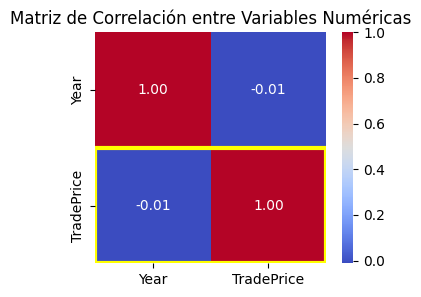

In [48]:
correlation_heatmap(df_number[["Year", "TradePrice"]].copy())

Fill NaN with mean

In [49]:
max_mean_value = df_number['MaxTimeToNearestStation'].mean()
min_mean_value = df_number['MinTimeToNearestStation'].mean()

In [50]:
df_number['MaxTimeToNearestStation'] = df_number['MaxTimeToNearestStation'].fillna(max_mean_value)
df_number['MinTimeToNearestStation'] = df_number['MinTimeToNearestStation'].fillna(max_mean_value)

In [51]:
df_number.isnull().sum()

No                               0
MinTimeToNearestStation          0
MaxTimeToNearestStation          0
TradePrice                       0
Area                             0
UnitPrice                  2506097
PricePerTsubo              2506097
Frontage                   1353881
TotalFloorArea             2570280
BuildingYear                     0
Breadth                    1205286
CoverageRatio               706346
FloorAreaRatio              706346
Year                             0
Quarter                          0
dtype: int64

 UnitPrice column containg a big number of NaN

In [52]:
nan_coinciden = df_number['UnitPrice'].isna() == df_number['PricePerTsubo'].isna()

# Imprimir el resultado
print(nan_coinciden)  # Esto mostrará una serie booleana
print(nan_coinciden.all())

0          True
1          True
2          True
3          True
4          True
           ... 
3906513    True
3906514    True
3906515    True
3906516    True
3906517    True
Length: 3887071, dtype: bool
True


In [53]:
df_filtrado = df_number[['TradePrice', 'Area', 'UnitPrice']]#.dropna(subset=['TradePrice', 'Area', 'UnitPrice'])
df_filtrado.head()

TradePrice  Area  UnitPrice
0    86000000  1100    78000.0
1    38000000   310   120000.0
2    19000000    95        NaN
3     5000000   290    17000.0
4    25000000   430    58000.0

Sometimes the TradePrine is not equual to Area x UnitPrice
1100 x 78000 = 85.8000


In [54]:
df_filtrado["Perfect_Price"] = df_filtrado["Area"] * df_filtrado["UnitPrice"]
df_filtrado.head()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\1492233252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["Perfect_Price"] = df_filtrado["Area"] * df_filtrado["UnitPrice"]


TradePrice  Area  UnitPrice  Perfect_Price
0    86000000  1100    78000.0     85800000.0
1    38000000   310   120000.0     37200000.0
2    19000000    95        NaN            NaN
3     5000000   290    17000.0      4930000.0
4    25000000   430    58000.0     24940000.0

In [55]:
df_filtrado['Ratio_P/T_Price'] = df_filtrado['Perfect_Price'] / df_filtrado['TradePrice']
df_filtrado.head()

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\2558922893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Ratio_P/T_Price'] = df_filtrado['Perfect_Price'] / df_filtrado['TradePrice']


TradePrice  Area  UnitPrice  Perfect_Price  Ratio_P/T_Price
0    86000000  1100    78000.0     85800000.0         0.997674
1    38000000   310   120000.0     37200000.0         0.978947
2    19000000    95        NaN            NaN              NaN
3     5000000   290    17000.0      4930000.0         0.986000
4    25000000   430    58000.0     24940000.0         0.997600

In [56]:
mean_ratio = df_filtrado['Ratio_P/T_Price'].mean()
mean_ratio
#En un futuro se podria hacer un ratio por prefecture

0.9820303249588133

In [57]:
#solo para rellenar NaN
df_filtrado['Perfect_Price'] = df_filtrado['Perfect_Price'].fillna(df_filtrado['TradePrice'] * mean_ratio)
df_filtrado

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\1492852357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Perfect_Price'] = df_filtrado['Perfect_Price'].fillna(df_filtrado['TradePrice'] * mean_ratio)


TradePrice  Area  UnitPrice  Perfect_Price  Ratio_P/T_Price
0          86000000  1100    78000.0   8.580000e+07         0.997674
1          38000000   310   120000.0   3.720000e+07         0.978947
2          19000000    95        NaN   1.865858e+07              NaN
3           5000000   290    17000.0   4.930000e+06         0.986000
4          25000000   430    58000.0   2.494000e+07         0.997600
...             ...   ...        ...            ...              ...
3906513     1700000  5000        NaN   1.669452e+06              NaN
3906514      930000  4600        NaN   9.132882e+05              NaN
3906515       40000   100        NaN   3.928121e+04              NaN
3906516      170000   440        NaN   1.669452e+05              NaN
3906517       57000   145        NaN   5.597573e+04              NaN

[3887071 rows x 5 columns]

In [58]:
#solo para rellenar NaN
df_filtrado['UnitPrice'] = df_filtrado['UnitPrice'].fillna(df_filtrado['Perfect_Price'] / df_filtrado['Area'])
df_filtrado

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\2266486678.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['UnitPrice'] = df_filtrado['UnitPrice'].fillna(df_filtrado['Perfect_Price'] / df_filtrado['Area'])


TradePrice  Area      UnitPrice  Perfect_Price  Ratio_P/T_Price
0          86000000  1100   78000.000000   8.580000e+07         0.997674
1          38000000   310  120000.000000   3.720000e+07         0.978947
2          19000000    95  196406.064992   1.865858e+07              NaN
3           5000000   290   17000.000000   4.930000e+06         0.986000
4          25000000   430   58000.000000   2.494000e+07         0.997600
...             ...   ...            ...            ...              ...
3906513     1700000  5000     333.890310   1.669452e+06              NaN
3906514      930000  4600     198.540914   9.132882e+05              NaN
3906515       40000   100     392.812130   3.928121e+04              NaN
3906516      170000   440     379.420807   1.669452e+05              NaN
3906517       57000   145     386.039507   5.597573e+04              NaN

[3887071 rows x 5 columns]

In [59]:
df_filtrado.corr()

TradePrice      Area  UnitPrice  Perfect_Price  \
TradePrice         1.000000  0.035101   0.407275       0.905819   
Area               0.035101  1.000000  -0.206724       0.021590   
UnitPrice          0.407275 -0.206724   1.000000       0.465427   
Perfect_Price      0.905819  0.021590   0.465427       1.000000   
Ratio_P/T_Price   -0.240717 -0.526524   0.049926      -0.078842   

                 Ratio_P/T_Price  
TradePrice             -0.240717  
Area                   -0.526524  
UnitPrice               0.049926  
Perfect_Price          -0.078842  
Ratio_P/T_Price         1.000000

In [60]:
df_number[['TradePrice', 'Area', 'UnitPrice',"Perfect_Price"]] = df_filtrado[['TradePrice', 'Area', 'UnitPrice',"Perfect_Price"]]

In [61]:
df_number.isnull().sum()

No                               0
MinTimeToNearestStation          0
MaxTimeToNearestStation          0
TradePrice                       0
Area                             0
UnitPrice                        0
PricePerTsubo              2506097
Frontage                   1353881
TotalFloorArea             2570280
BuildingYear                     0
Breadth                    1205286
CoverageRatio               706346
FloorAreaRatio              706346
Year                             0
Quarter                          0
Perfect_Price                    0
dtype: int64

In [62]:
#IDEA: get the number of rooms from compute_floor_plan function get the average room area and calculate TotalFloorArea (NOT DONE)

In [63]:
df_number.columns

Index(['No', 'MinTimeToNearestStation', 'MaxTimeToNearestStation',
       'TradePrice', 'Area', 'UnitPrice', 'PricePerTsubo', 'Frontage',
       'TotalFloorArea', 'BuildingYear', 'Breadth', 'CoverageRatio',
       'FloorAreaRatio', 'Year', 'Quarter', 'Perfect_Price'],
      dtype='object')

In [64]:
df_number["TotalFloorAreaIsGreaterFlag"] = df["TotalFloorAreaIsGreaterFlag"]

In [65]:
df_number[['TradePrice',"Perfect_Price", 'Area', "TotalFloorArea","TotalFloorAreaIsGreaterFlag",'CoverageRatio', "Frontage","Breadth","FloorAreaRatio"]].head(30)

TradePrice  Perfect_Price  Area  TotalFloorArea  \
0     86000000   8.580000e+07  1100             NaN   
1     38000000   3.720000e+07   310             NaN   
2     19000000   1.865858e+07    95             NaN   
3      5000000   4.930000e+06   290             NaN   
4     25000000   2.494000e+07   430             NaN   
5     18000000   1.800000e+07   300             NaN   
6     33000000   3.354000e+07   390             NaN   
7     61000000   6.020000e+07   430             NaN   
8     20000000   1.980000e+07   165             NaN   
9     14000000   1.374842e+07    90             NaN   
10     3800000   3.731715e+06    60            70.0   
11    25000000   2.455076e+07   580           170.0   
12    40000000   3.928121e+07   400           190.0   
13    27000000   2.651482e+07    80             NaN   
14    14000000   1.394000e+07   170             NaN   
15    27000000   2.684000e+07   440             NaN   
16    29000000   2.881000e+07   430             NaN   
17    23000000   2.380000e+07   170             NaN   
18    38000000   3.731715e+07   185           110.0   
19    30000000   2.946091e+07   120             NaN   
20    23000000   2.294000e+07   370             NaN   
21    24000000   2.356873e+07   240           170.0   
22    33000000   3.240700e+07   330           185.0   
23    30000000   3.010000e+07   350             NaN   
24    19000000   1.865858e+07    95             NaN   
25    31000000   3.120000e+07   260             NaN   
26    54000000   5.402000e+07   730             NaN   
27    30000000   2.946091e+07   270           155.0   
28    18000000   1.767655e+07   750            80.0   
29   370000000   3.633512e+08   330          2000.0   

    TotalFloorAreaIsGreaterFlag  CoverageRatio  Frontage  Breadth  \
0                         False           40.0      34.0     10.2   
1                         False           40.0      21.5      7.2   
2                         False           80.0       NaN      NaN   
3                         False           40.0       7.0      4.0   
4                         False           40.0      16.0      7.2   
5                         False           40.0      10.0      7.2   
6                         False           40.0      10.0      7.2   
7                         False           40.0      16.0      7.0   
8                         False           40.0      12.6     11.0   
9                         False           40.0       NaN      NaN   
10                        False           60.0       5.1     14.5   
11                        False           40.0      50.0     16.0   
12                        False           40.0      14.0     10.2   
13                        False           60.0       NaN      NaN   
14                        False           40.0       6.6      7.2   
15                        False           40.0      20.0      4.0   
16                        False           40.0      15.8      7.2   
17                        False           60.0      12.6     15.0   
18                        False           40.0      15.0      6.0   
19                        False           60.0       NaN      NaN   
20                        False           40.0       NaN      6.5   
21                        False           40.0      12.7      8.5   
22                        False           40.0      23.0      7.2   
23                        False           40.0      12.7     14.5   
24                        False            NaN       NaN      NaN   
25                        False           40.0      15.0      5.5   
26                        False           60.0      25.0      6.0   
27                        False            NaN       NaN      NaN   
28                        False           40.0       NaN      4.0   
29                         True           80.0      14.5     20.0   

    FloorAreaRatio  
0             80.0  
1             80.0  
2            200.0  
3             80.0  
4             80.0  
5             80.0  
6          

In [66]:
#MaxBaseCoverage = Area * CoverageRatio

df_number['MaxBaseCoverage'] = (df_number['CoverageRatio']/100) * df_number['Area']
df_number['MaxTotalArea'] = (df_number['FloorAreaRatio']/100) * df_number['Area']

In [67]:
df_number[['TradePrice',"Perfect_Price", 'Area', "TotalFloorArea","TotalFloorAreaIsGreaterFlag",'CoverageRatio', "Frontage","Breadth","FloorAreaRatio","MaxBaseCoverage","MaxTotalArea"]].corr()

TradePrice  Perfect_Price      Area  \
TradePrice                     1.000000       0.905819  0.035101   
Perfect_Price                  0.905819       1.000000  0.021590   
Area                           0.035101       0.021590  1.000000   
TotalFloorArea                 0.370897       0.370897  0.611960   
TotalFloorAreaIsGreaterFlag    0.285772       0.328797  0.066424   
CoverageRatio                  0.041197       0.046524 -0.052399   
Frontage                       0.118446       0.097673  0.742095   
Breadth                        0.137287       0.135995  0.160872   
FloorAreaRatio                 0.083724       0.094578 -0.095958   
MaxBaseCoverage                0.192199       0.168554  0.986236   
MaxTotalArea                   0.255341       0.238403  0.912438   

                             TotalFloorArea  TotalFloorAreaIsGreaterFlag  \
TradePrice                         0.370897                     0.285772   
Perfect_Price                      0.370897                     0.328797   
Area                               0.611960                     0.066424   
TotalFloorArea                     1.000000                     0.665481   
TotalFloorAreaIsGreaterFlag        0.665481                     1.000000   
CoverageRatio                      0.217044                     0.040222   
Frontage                           0.480912                     0.142547   
Breadth                            0.327969                     0.113128   
FloorAreaRatio                     0.283519                     0.056427   
MaxBaseCoverage                    0.654763                     0.209990   
MaxTotalArea                       0.690295                     0.250830   

                             CoverageRatio  Frontage   Breadth  \
TradePrice                        0.041197  0.118446  0.137287   
Perfect_Price                     0.046524  0.097673  0.135995   
Area                             -0.052399  0.742095  0.160872   
TotalFloorArea                    0.217044  0.480912  0.327969   
TotalFloorAreaIsGreaterFlag       0.040222  0.142547  0.113128   
CoverageRatio                     1.000000  0.020166  0.190522   
Frontage                          0.020166  1.000000  0.150010   
Breadth                           0.190522  0.150010  1.000000   
FloorAreaRatio                    0.788926  0.001146  0.236714   
MaxBaseCoverage                   0.046257  0.733335  0.192552   
MaxTotalArea                      0.146745  0.671280  0.231240   

                             FloorAreaRatio  MaxBaseCoverage  MaxTotalArea  
TradePrice                         0.083724         0.192199      0.255341  
Perfect_Price                      0.094578         0.168554      0.238403  
Area                              -0.095958         0.986236      0.912438  
TotalFloorArea                     0.283519         0.654763      0.690295  
TotalFloorAreaIsGreaterFlag        0.056427         0.209990      0.250830  
CoverageRatio                      0.788926         0.046257      0.146745  
Frontage                           0.001146         0.733335      0.671280  
Breadth                            0.236714         0.192552      0.231240  
FloorAreaRatio                     1.000000        -0.029748      0.130680  
MaxBaseCoverage                   -0.029748         1.000000      0.949089  
MaxTotalArea                       0.130680         0.949089      1.000000

In [68]:
df_number[['TradePrice',"Perfect_Price", 'Area', "TotalFloorArea","TotalFloorAreaIsGreaterFlag",'CoverageRatio', "Frontage","Breadth","FloorAreaRatio","MaxBaseCoverage","MaxTotalArea"]].head(30)

TradePrice  Perfect_Price  Area  TotalFloorArea  \
0     86000000   8.580000e+07  1100             NaN   
1     38000000   3.720000e+07   310             NaN   
2     19000000   1.865858e+07    95             NaN   
3      5000000   4.930000e+06   290             NaN   
4     25000000   2.494000e+07   430             NaN   
5     18000000   1.800000e+07   300             NaN   
6     33000000   3.354000e+07   390             NaN   
7     61000000   6.020000e+07   430             NaN   
8     20000000   1.980000e+07   165             NaN   
9     14000000   1.374842e+07    90             NaN   
10     3800000   3.731715e+06    60            70.0   
11    25000000   2.455076e+07   580           170.0   
12    40000000   3.928121e+07   400           190.0   
13    27000000   2.651482e+07    80             NaN   
14    14000000   1.394000e+07   170             NaN   
15    27000000   2.684000e+07   440             NaN   
16    29000000   2.881000e+07   430             NaN   
17    23000000   2.380000e+07   170             NaN   
18    38000000   3.731715e+07   185           110.0   
19    30000000   2.946091e+07   120             NaN   
20    23000000   2.294000e+07   370             NaN   
21    24000000   2.356873e+07   240           170.0   
22    33000000   3.240700e+07   330           185.0   
23    30000000   3.010000e+07   350             NaN   
24    19000000   1.865858e+07    95             NaN   
25    31000000   3.120000e+07   260             NaN   
26    54000000   5.402000e+07   730             NaN   
27    30000000   2.946091e+07   270           155.0   
28    18000000   1.767655e+07   750            80.0   
29   370000000   3.633512e+08   330          2000.0   

    TotalFloorAreaIsGreaterFlag  CoverageRatio  Frontage  Breadth  \
0                         False           40.0      34.0     10.2   
1                         False           40.0      21.5      7.2   
2                         False           80.0       NaN      NaN   
3                         False           40.0       7.0      4.0   
4                         False           40.0      16.0      7.2   
5                         False           40.0      10.0      7.2   
6                         False           40.0      10.0      7.2   
7                         False           40.0      16.0      7.0   
8                         False           40.0      12.6     11.0   
9                         False           40.0       NaN      NaN   
10                        False           60.0       5.1     14.5   
11                        False           40.0      50.0     16.0   
12                        False           40.0      14.0     10.2   
13                        False           60.0       NaN      NaN   
14                        False           40.0       6.6      7.2   
15                        False           40.0      20.0      4.0   
16                        False           40.0      15.8      7.2   
17                        False           60.0      12.6     15.0   
18                        False           40.0      15.0      6.0   
19                        False           60.0       NaN      NaN   
20                        False           40.0       NaN      6.5   
21                        False           40.0      12.7      8.5   
22                        False           40.0      23.0      7.2   
23                        False           40.0      12.7     14.5   
24                        False            NaN       NaN      NaN   
25                        False           40.0      15.0      5.5   
26                        False           60.0      25.0      6.0   
27                        False            NaN       NaN      NaN   
28                        False           40.0       NaN      4.0   
29                         True           80.0      14.5     20.0   

    FloorAreaRatio  MaxBaseCoverage  MaxTotalArea  
0             80.0            440.0         880.0  
1             80.0            124.0         248.0  
2 

In [69]:
#df_number['TotalFloorArea'] = df['TotalFloorArea']
#fill TotalArea NaNs values with (MaxBaseCoverage + MaxTotalArea)/2
#df_number['TotalFloorArea'] = df_number['TotalFloorArea'].fillna((df_number['MaxBaseCoverage'] + df_number['MaxBaseCoverage'])/2) 0.284262
#df_number['TotalFloorArea'] = df_number['TotalFloorArea'].fillna(df_number['MaxBaseCoverage'] ) 0.284262
#df_number['TotalFloorArea'] = df_number['TotalFloorArea'].fillna((df_number['MaxBaseCoverage'] + df_number['MaxBaseCoverage'])/4) 0.317579
#df_number['TotalFloorArea'] = df_number['TotalFloorArea'].fillna((df_number['MaxBaseCoverage']-df_number['MaxBaseCoverage']  )/4) 


#df_number['TotalFloorArea'] = df_number['TotalFloorArea'].fillna((df_number['TotalFloorArea'].mean()+df_number['MaxBaseCoverage'] + df_number['MaxBaseCoverage'])/6)#0.320839
#none of them improved correlation
#df_number[['TradePrice', 'Area', "TotalFloorArea","TotalFloorAreaIsGreaterFlag",'CoverageRatio', "Frontage","Breadth","FloorAreaRatio","MaxBaseCoverage","MaxTotalArea"]].corr()

In [70]:
df_number['MaxPerfectPrice'] = df_number['Perfect_Price'] * df_number['MaxTotalArea']
df_number['CoveragePerfectPrice'] = df_number['Perfect_Price'] * df_number['MaxTotalArea']

In [71]:
 df_number[['TradePrice', "Perfect_Price","MaxPerfectPrice", "CoveragePerfectPrice",'Area', "TotalFloorArea","TotalFloorAreaIsGreaterFlag",'CoverageRatio', "Frontage","Breadth","FloorAreaRatio","MaxBaseCoverage","MaxTotalArea"]].corr()

TradePrice  Perfect_Price  MaxPerfectPrice  \
TradePrice                     1.000000       0.905819         0.771438   
Perfect_Price                  0.905819       1.000000         0.847581   
MaxPerfectPrice                0.771438       0.847581         1.000000   
CoveragePerfectPrice           0.771438       0.847581         1.000000   
Area                           0.035101       0.021590         0.106429   
TotalFloorArea                 0.370897       0.370897         0.196324   
TotalFloorAreaIsGreaterFlag    0.285772       0.328797         0.221246   
CoverageRatio                  0.041197       0.046524         0.031112   
Frontage                       0.118446       0.097673         0.077255   
Breadth                        0.137287       0.135995         0.079010   
FloorAreaRatio                 0.083724       0.094578         0.055480   
MaxBaseCoverage                0.192199       0.168554         0.121885   
MaxTotalArea                   0.255341       0.238403         0.195049   

                             CoveragePerfectPrice      Area  TotalFloorArea  \
TradePrice                               0.771438  0.035101        0.370897   
Perfect_Price                            0.847581  0.021590        0.370897   
MaxPerfectPrice                          1.000000  0.106429        0.196324   
CoveragePerfectPrice                     1.000000  0.106429        0.196324   
Area                                     0.106429  1.000000        0.611960   
TotalFloorArea                           0.196324  0.611960        1.000000   
TotalFloorAreaIsGreaterFlag              0.221246  0.066424        0.665481   
CoverageRatio                            0.031112 -0.052399        0.217044   
Frontage                                 0.077255  0.742095        0.480912   
Breadth                                  0.079010  0.160872        0.327969   
FloorAreaRatio                           0.055480 -0.095958        0.283519   
MaxBaseCoverage                          0.121885  0.986236        0.654763   
MaxTotalArea                             0.195049  0.912438        0.690295   

                             TotalFloorAreaIsGreaterFlag  CoverageRatio  \
TradePrice                                      0.285772       0.041197   
Perfect_Price                                   0.328797       0.046524   
MaxPerfectPrice                                 0.221246       0.031112   
CoveragePerfectPrice                            0.221246       0.031112   
Area                                            0.066424      -0.052399   
TotalFloorArea                                  0.665481       0.217044   
TotalFloorAreaIsGreaterFlag                     1.000000       0.040222   
CoverageRatio                                   0.040222       1.000000   
Frontage                                        0.142547       0.020166   
Breadth                                         0.113128       0.190522   
FloorAreaRatio                                  0.056427       0.788926   
MaxBaseCoverage                                 0.209990       0.046257   
MaxTotalArea                                    0.250830       0.146745   

                             Frontage   Breadth  FloorAreaRatio  \
TradePrice                   0.118446  0.137287        0.083724   
Perfect_Price                0.097673  0.135995        0.094578   
MaxPerfectPrice              0.077255  0.079010        0.055480   
CoveragePerfectPrice         0.077255  0.079010        0.055480   
Area                         0.742095  0.160872       -0.095958   
TotalFloorArea               0.480912  0.327969        0.283519   
TotalFloorAreaIsGreaterFlag  0.142547  0.113128        0.056427   
CoverageRatio                0.020166  0.190522        0.788926   
Frontage                     1.000000  0.150010        0.001146   
Breadth                      0.150010  1.000000        0.236714   
FloorAreaRatio               0.001146  0.236714        1.000000   
MaxBaseCoverage 

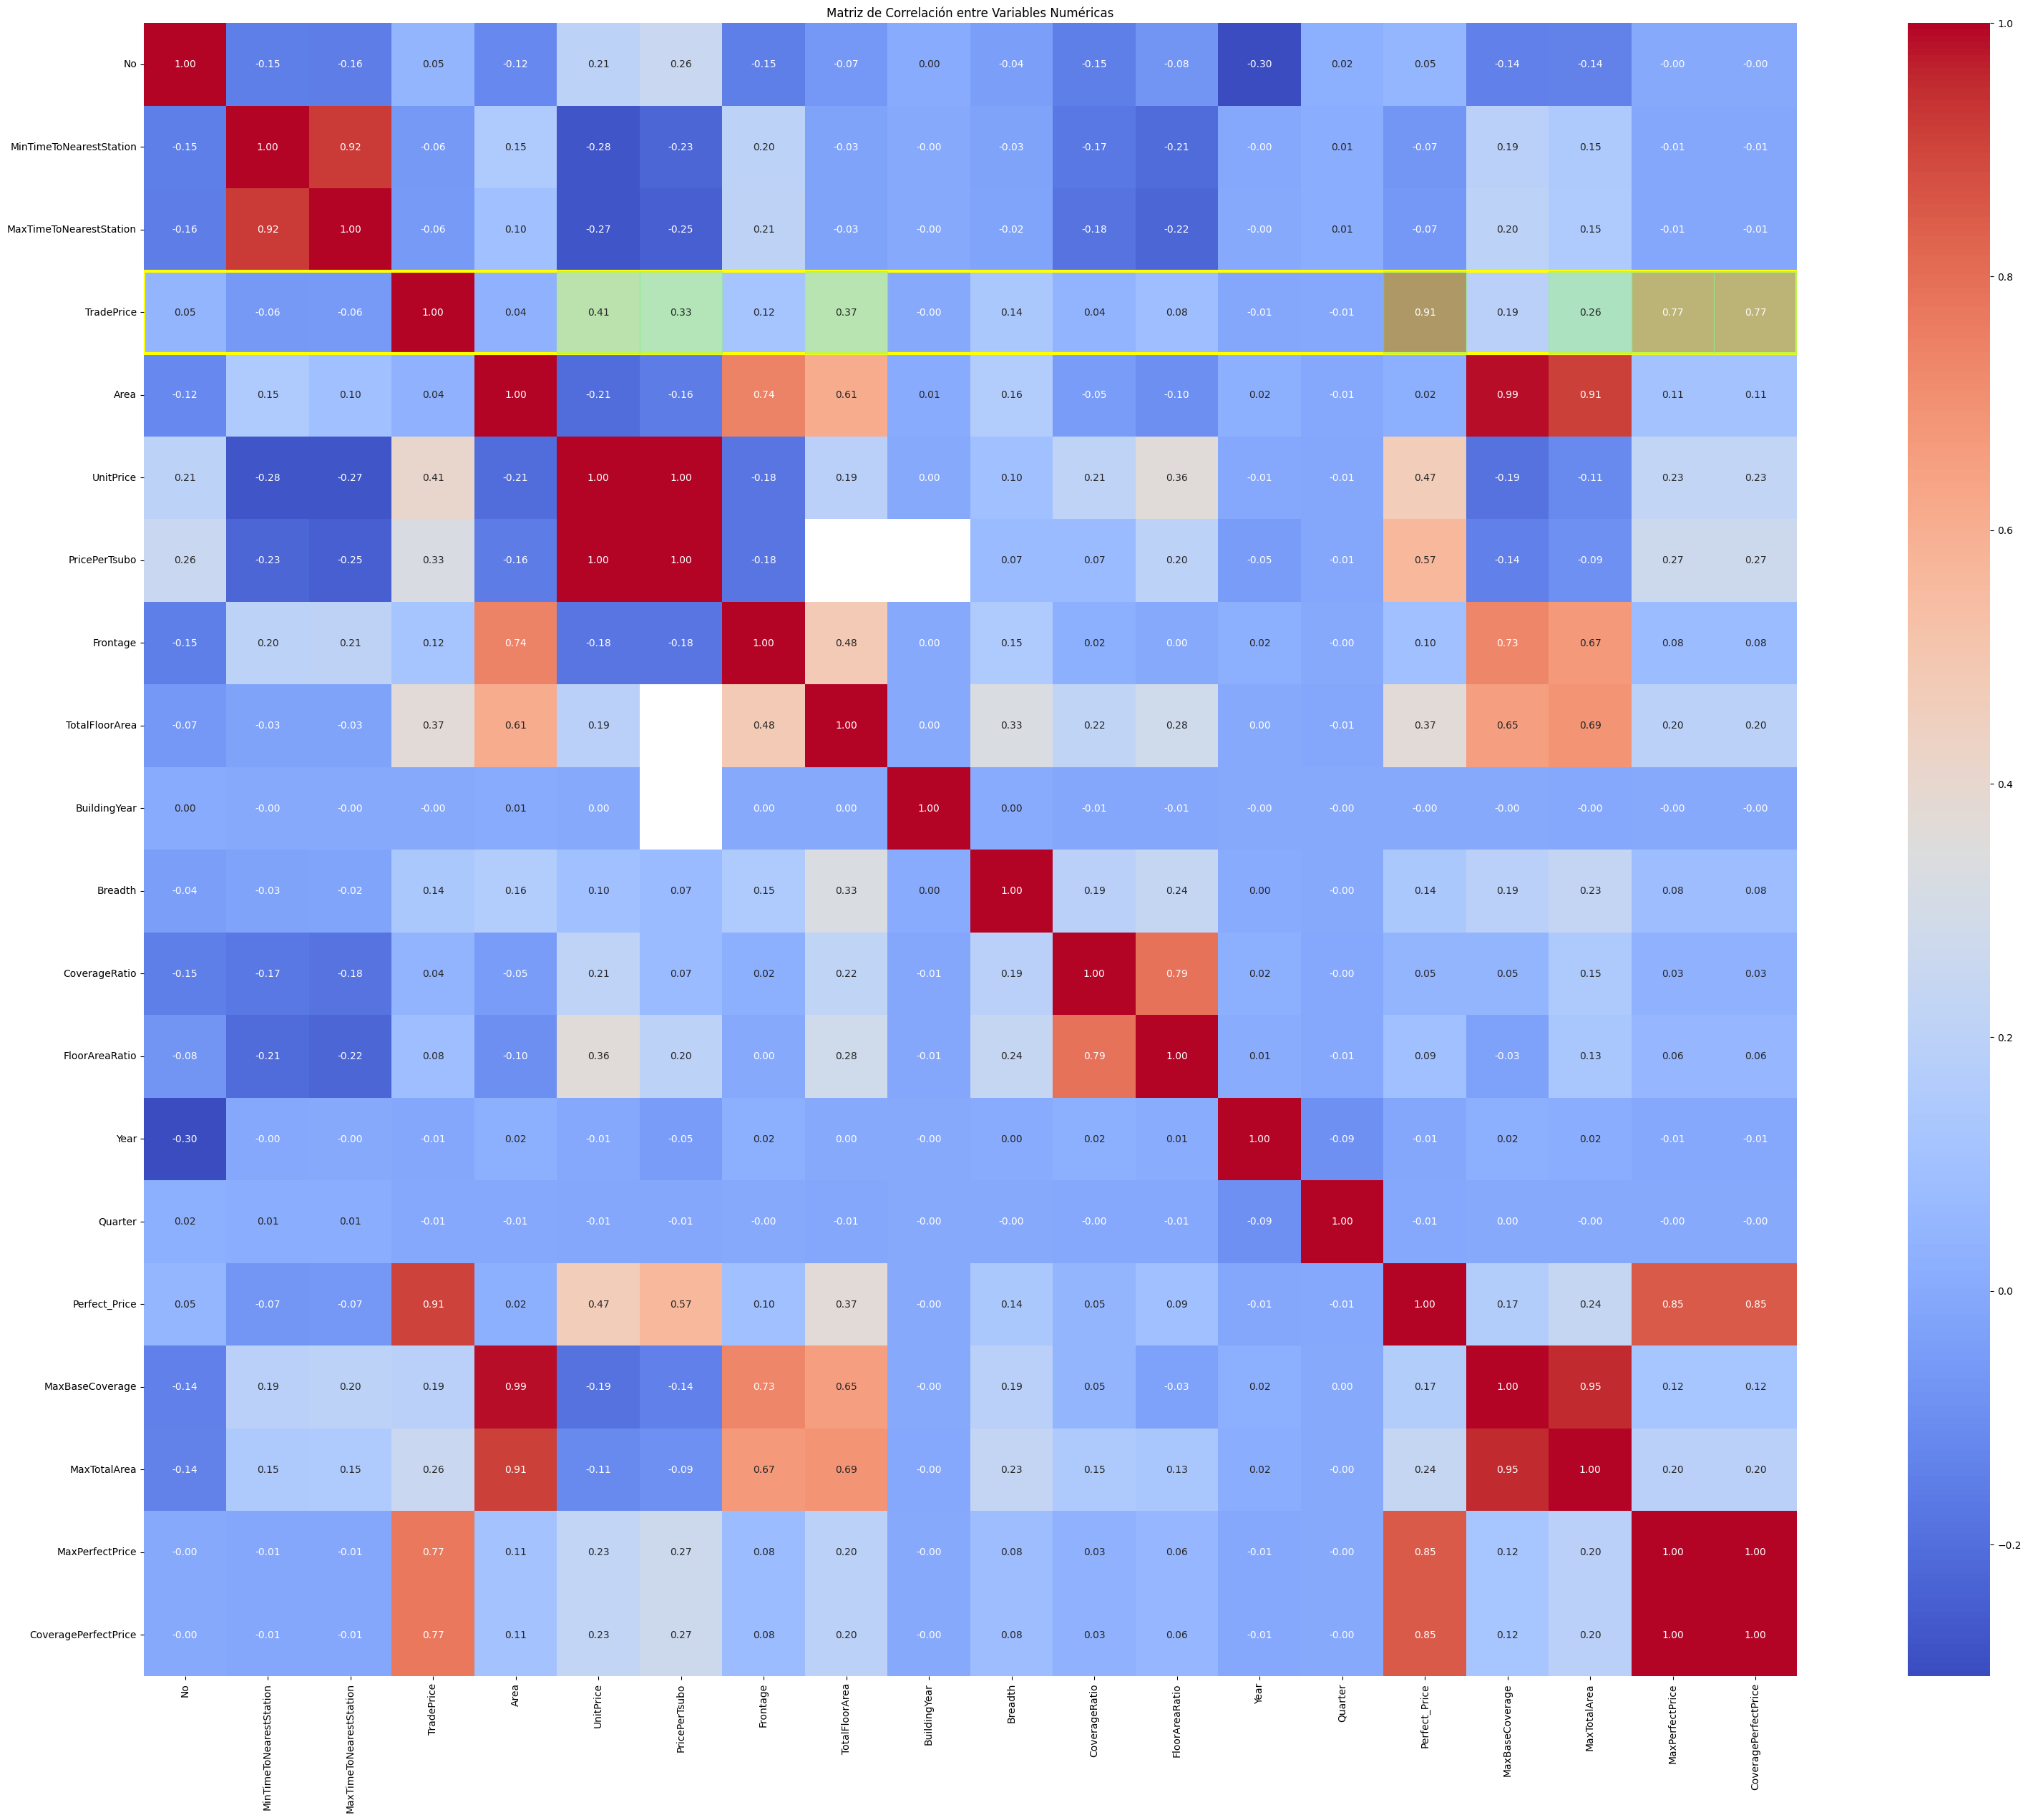

In [72]:
correlation_heatmap(df_number)

Linear correlations are improved. 

In [73]:
df.shape

(3887071, 38)

In [74]:
df_number.shape

(3887071, 21)

In [75]:
for col in df_number.columns:
    df[col] = df_number[col]


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\2055085105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df_number[col]
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\2055085105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df_number[col]
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\2055085105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [76]:
df.shape

(3887071, 43)

In [77]:
df.columns

Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks', 'Perfect_Price', 'MaxBaseCoverage',
       'MaxTotalArea', 'MaxPerfectPrice', 'CoveragePerfectPrice'],
      dtype='object')

Lets have a look at categorical columns

In [78]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
categorical_cols

Index(['Type', 'Region', 'MunicipalityCode', 'Prefecture', 'Municipality',
       'DistrictName', 'NearestStation', 'TimeToNearestStation', 'FloorPlan',
       'LandShape', 'Structure', 'Use', 'Purpose', 'Direction',
       'Classification', 'CityPlanning', 'Period', 'Renovation', 'Remarks'],
      dtype='object')

In [79]:
for var in categorical_cols:
    print("------Value counts de: ", var)
    print(df[var].value_counts(dropna=False))

------Value counts de:  Type
Type
residential land(land and building)    1404103
residential land(land only)            1380974
pre-owned condominiums, etc.            610520
agricultural land                       329495
forest land                             161979
Name: count, dtype: int64
------Value counts de:  Region
Region
residential area              2394027
NaN                           1101994
commercial area                206694
potential residential area     132332
industrial area                 52024
Name: count, dtype: int64
------Value counts de:  MunicipalityCode
MunicipalityCode
13112    26167
13111    22489
13120    21972
13121    18381
13115    17734
         ...  
15586        9
7364         6
46304        6
47356        2
46303        2
Name: count, Length: 1893, dtype: int64
------Value counts de:  Prefecture
Prefecture
tokyo                   402959
kanagawa prefecture     278903
osaka prefecture        233517
saitama prefecture      208353
aichi prefecture  

There are many NaN values in the data, there are many ways to deal with this such as replacing by mean, most frequent or generate another category. In this case, NaN values are addressed by one-hot encoding will be done and NaN values are not in account, therefore all generated columns will be zero. This way reflects the original data without losing potentially valuable information.

Feature engineering

- One Hot : Type, LandShape, Direction, Classification, CityPlanning, Purpose, Region, Renovation
- One Hot Tunned: FloorPlan, Structure, Use, Remarks, CityPlanning
- Phase 3: MunicipalityCode, Prefecture, DistrictName, NearestStation

One Hot : Type, LandShape, Direction, Classification, CityPlanning, Purpose

In [80]:
df.columns

Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks', 'Perfect_Price', 'MaxBaseCoverage',
       'MaxTotalArea', 'MaxPerfectPrice', 'CoveragePerfectPrice'],
      dtype='object')

In [81]:


columns_to_encode = ['Type', 'LandShape', 'Direction', 'Classification', 'Purpose', 'Region','Renovation']
to_delete.extend(columns_to_encode)

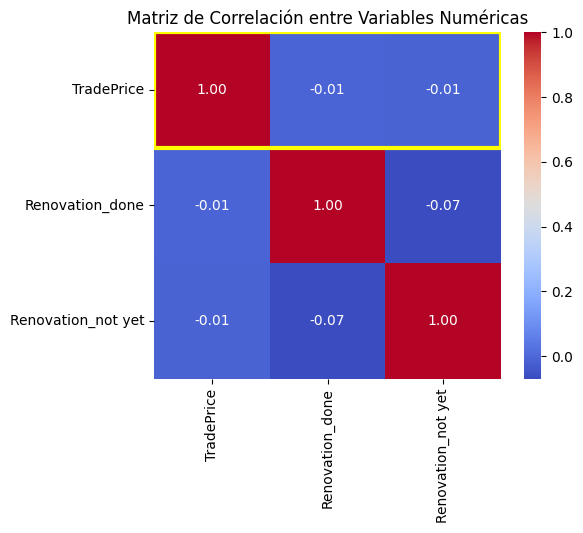


Análisis para la columna: Renovation


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan

Análisis para la columna: Renovation_done
Mann-Whitney U Test:
U-statistic: 247325526501.0, P-value: 0.0

Análisis para la columna: Renovation_not yet
Mann-Whitney U Test:
U-statistic: 575109566723.0, P-value: 0.0


In [82]:
#even thought most of the values are NaN, it can b eusefull for future as renovations should be made.
df = make_dummies_analyze(df.copy(),"Renovation")

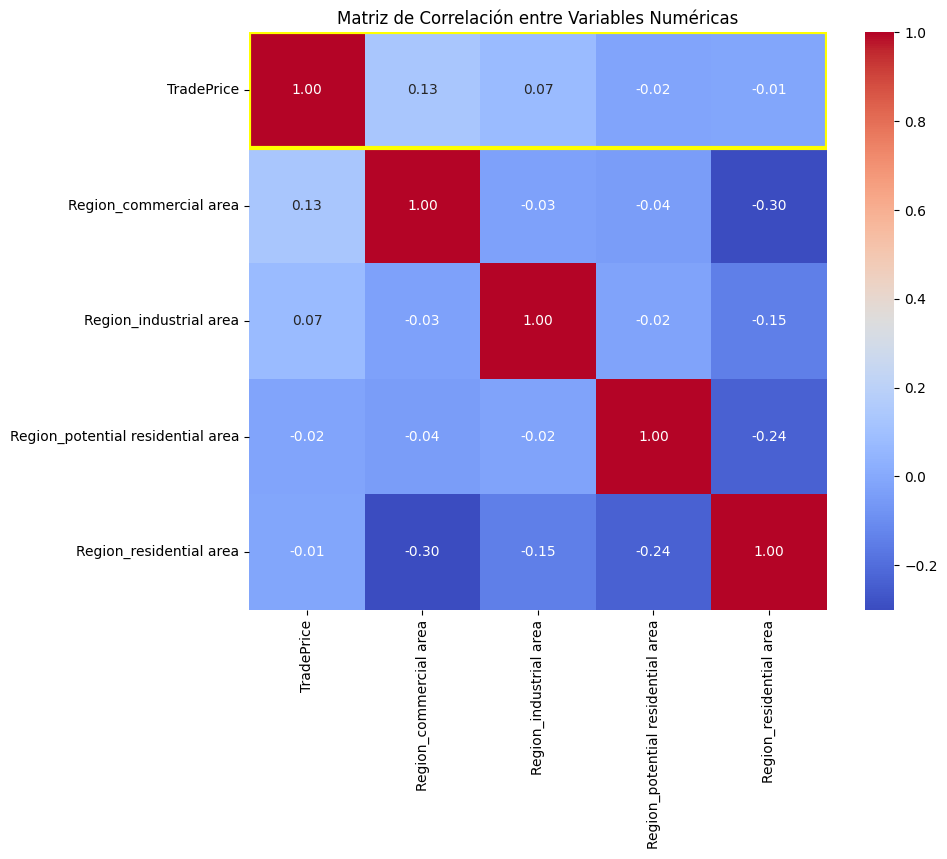


Análisis para la columna: Region


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan

Análisis para la columna: Region_commercial area
Mann-Whitney U Test:
U-statistic: 239215136179.0, P-value: 0.0

Análisis para la columna: Region_industrial area
Mann-Whitney U Test:
U-statistic: 57639713357.0, P-value: 0.0

Análisis para la columna: Region_potential residential area
Mann-Whitney U Test:
U-statistic: 327907334463.5, P-value: 0.0

Análisis para la columna: Region_residential area
Mann-Whitney U Test:
U-statistic: 2219057283511.5, P-value: 0.0


In [83]:
df = make_dummies_analyze(df.copy(),"Region")

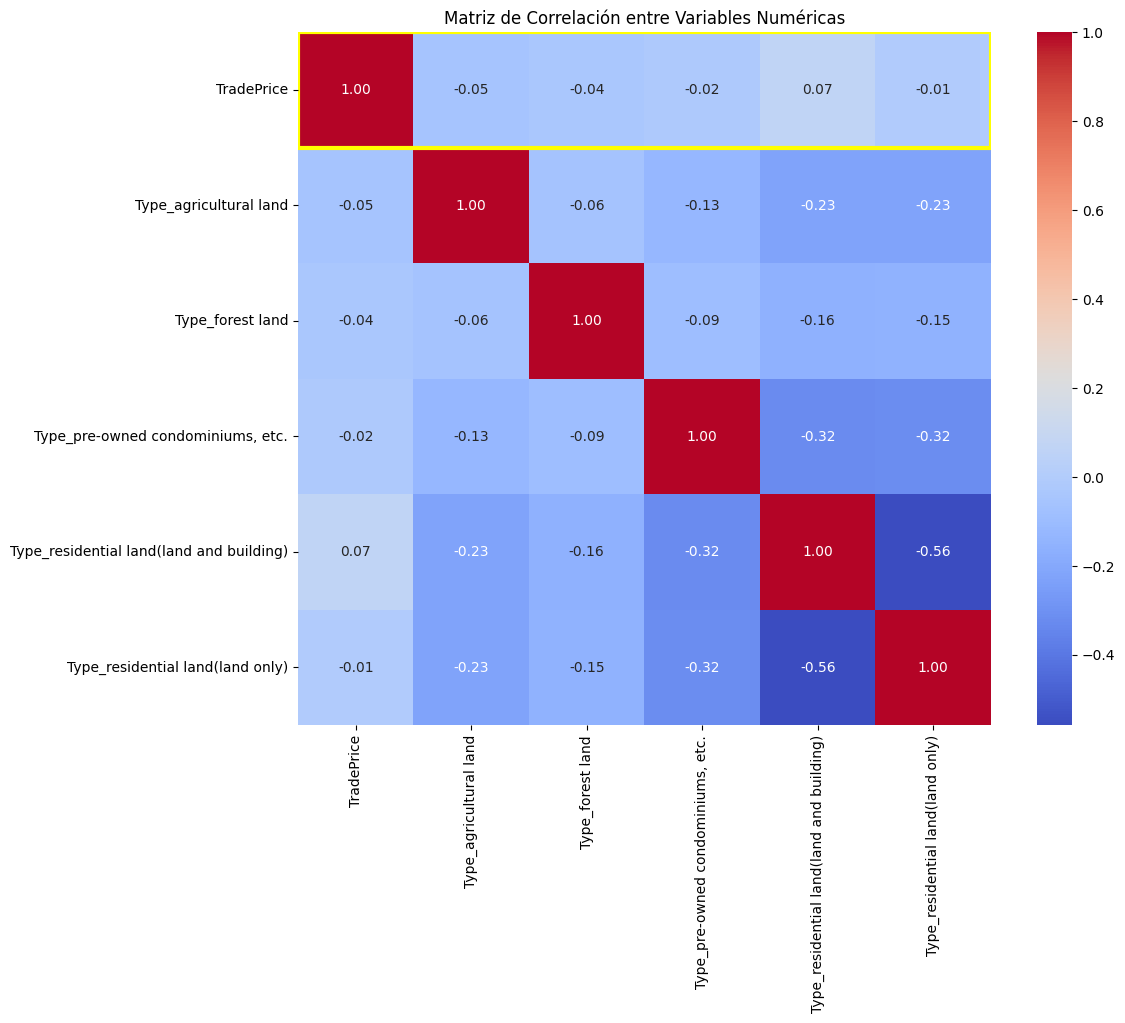


Análisis para la columna: Type
Kruskal-Wallis H Test:
H-statistic: 1187413.9545558908, P-value: 0.0

Análisis para la columna: Type_agricultural land
Mann-Whitney U Test:
U-statistic: 1050616894709.0, P-value: 0.0

Análisis para la columna: Type_forest land
Mann-Whitney U Test:
U-statistic: 552742409467.0, P-value: 0.0

Análisis para la columna: Type_pre-owned condominiums, etc.
Mann-Whitney U Test:
U-statistic: 820286245153.0, P-value: 0.0

Análisis para la columna: Type_residential land(land and building)
Mann-Whitney U Test:
U-statistic: 1020036264936.5, P-value: 0.0

Análisis para la columna: Type_residential land(land only)
Mann-Whitney U Test:
U-statistic: 1542942755798.5, P-value: 0.0


In [84]:
df = make_dummies_analyze(df.copy(),"Type")

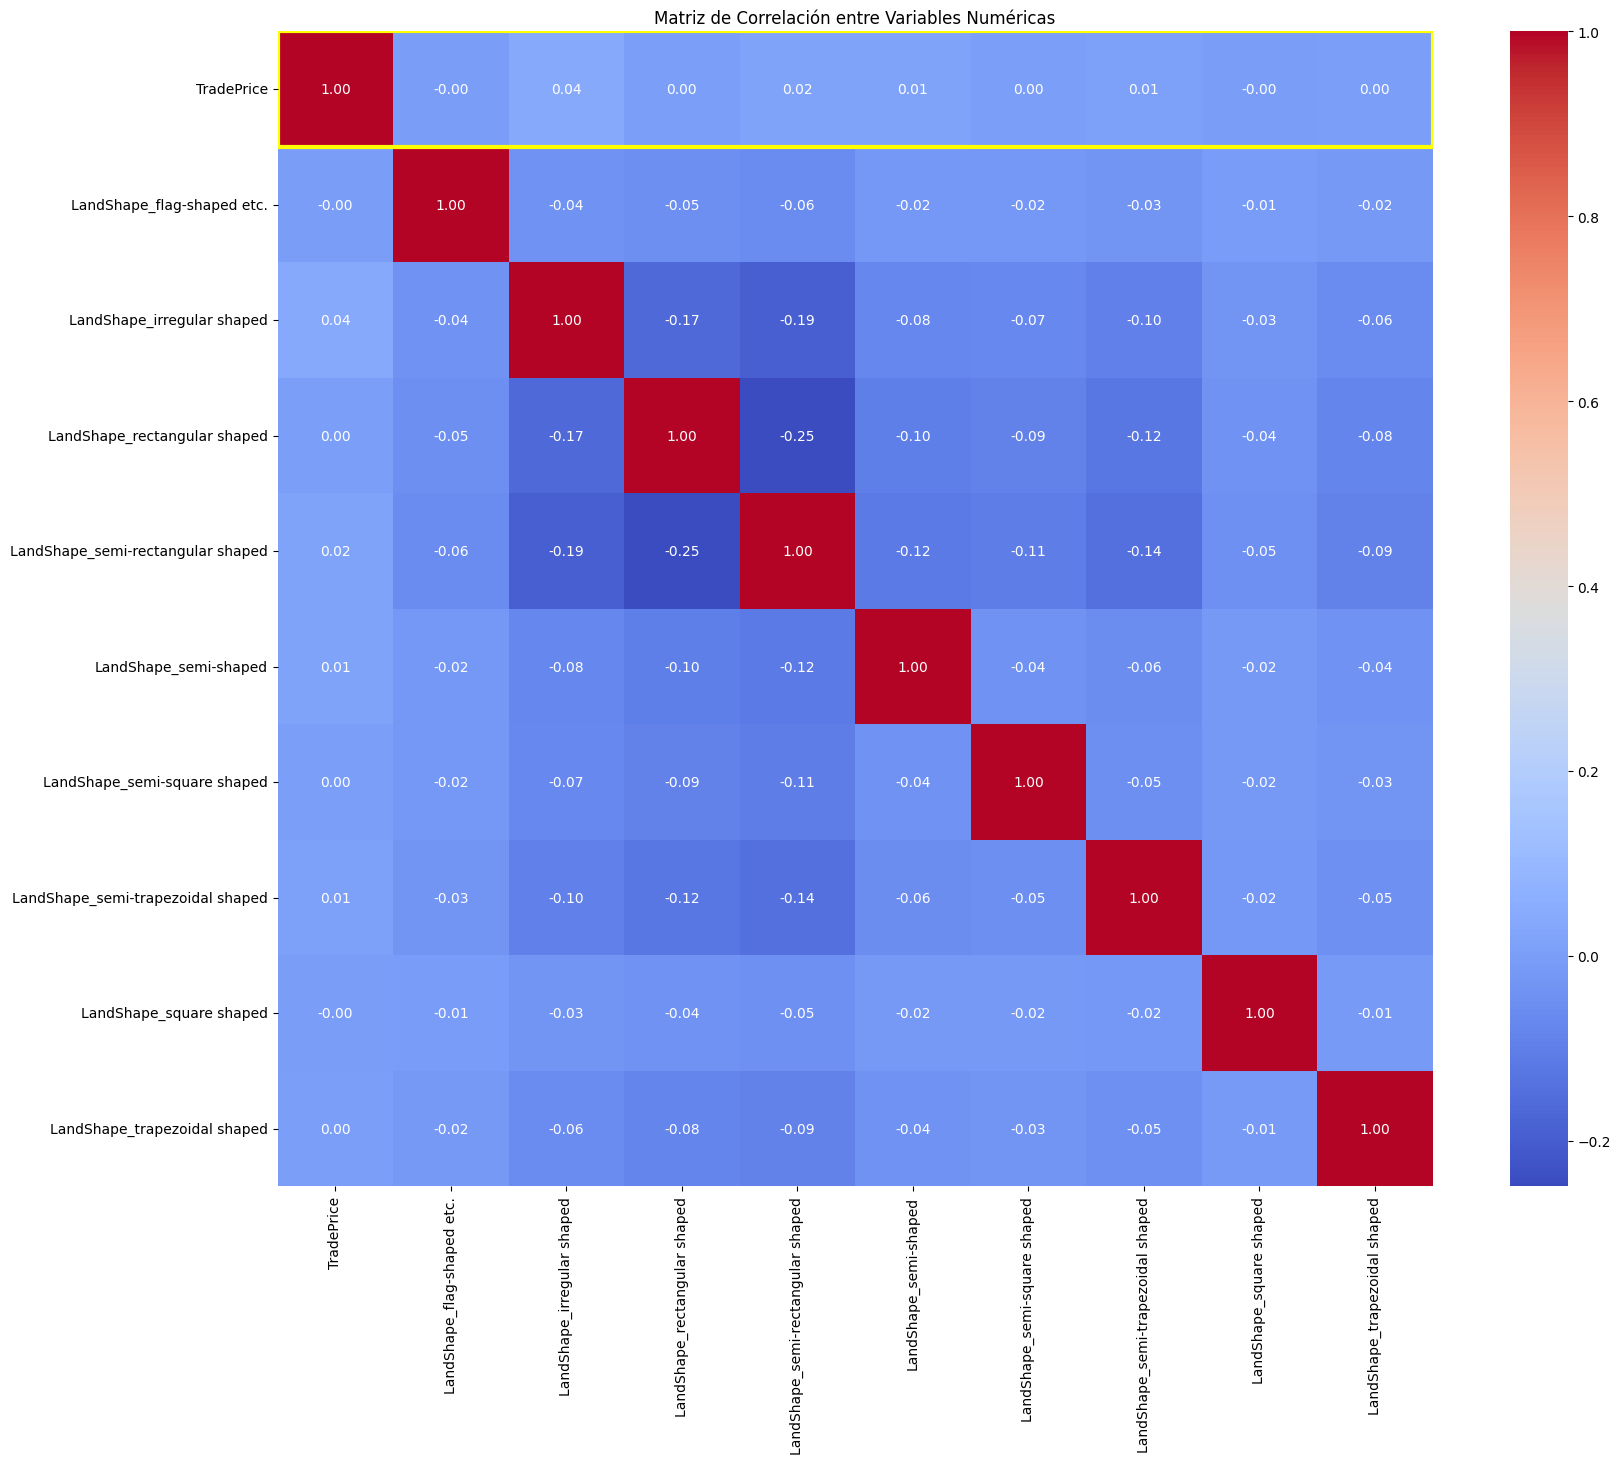


Análisis para la columna: LandShape


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan

Análisis para la columna: LandShape_flag-shaped etc.
Mann-Whitney U Test:
U-statistic: 70356071906.5, P-value: 0.0

Análisis para la columna: LandShape_irregular shaped
Mann-Whitney U Test:
U-statistic: 720165394128.0, P-value: 0.0

Análisis para la columna: LandShape_rectangular shaped
Mann-Whitney U Test:
U-statistic: 942084920035.0, P-value: 0.0

Análisis para la columna: LandShape_semi-rectangular shaped
Mann-Whitney U Test:
U-statistic: 1094440662703.0, P-value: 0.0

Análisis para la columna: LandShape_semi-shaped
Mann-Whitney U Test:
U-statistic: 315291457872.0, P-value: 1.0356340329681926e-161

Análisis para la columna: LandShape_semi-square shaped
Mann-Whitney U Test:
U-statistic: 243546306052.0, P-value: 0.0

Análisis para la columna: LandShape_semi-trapezoidal shaped
Mann-Whitney U Test:
U-statistic: 438273539069.0, P-value: 0.0

Análisis para la columna: LandShape_square shaped
Mann-Whitney U Test:
U-statistic: 526452997

In [85]:
df = make_dummies_analyze(df.copy(),"LandShape")


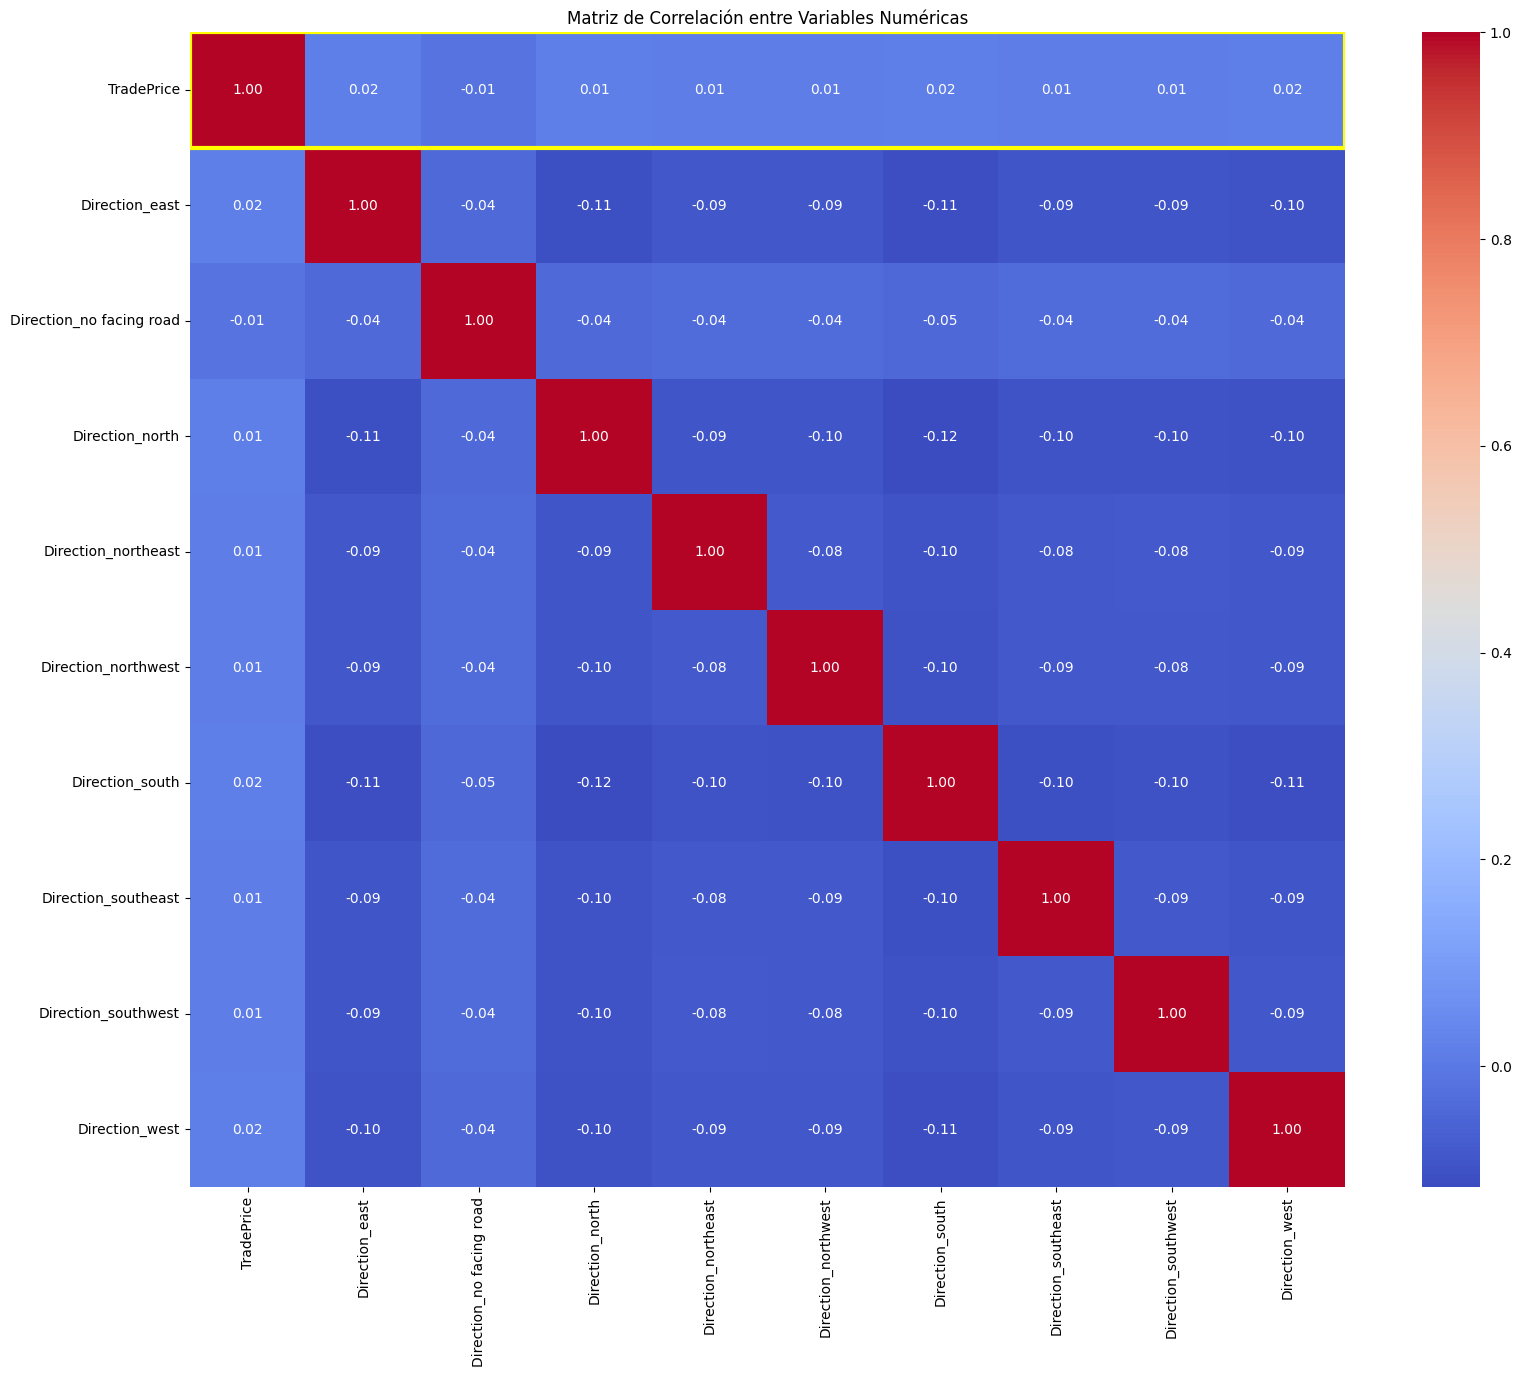


Análisis para la columna: Direction


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan

Análisis para la columna: Direction_east
Mann-Whitney U Test:
U-statistic: 546488739262.0, P-value: 0.0

Análisis para la columna: Direction_no facing road
Mann-Whitney U Test:
U-statistic: 172075259316.0, P-value: 0.0

Análisis para la columna: Direction_north
Mann-Whitney U Test:
U-statistic: 580885240945.5, P-value: 0.0

Análisis para la columna: Direction_northeast
Mann-Whitney U Test:
U-statistic: 465393834902.0, P-value: 0.0

Análisis para la columna: Direction_northwest
Mann-Whitney U Test:
U-statistic: 475210779457.5, P-value: 0.0

Análisis para la columna: Direction_south
Mann-Whitney U Test:
U-statistic: 859228204195.0, P-value: 0.0

Análisis para la columna: Direction_southeast
Mann-Whitney U Test:
U-statistic: 500536900975.5, P-value: 0.0

Análisis para la columna: Direction_southwest
Mann-Whitney U Test:
U-statistic: 484914182354.5, P-value: 0.0

Análisis para la columna: Direction_west
Mann-Whitney U Test:
U-statistic

In [86]:
df = make_dummies_analyze(df.copy(),"Direction")


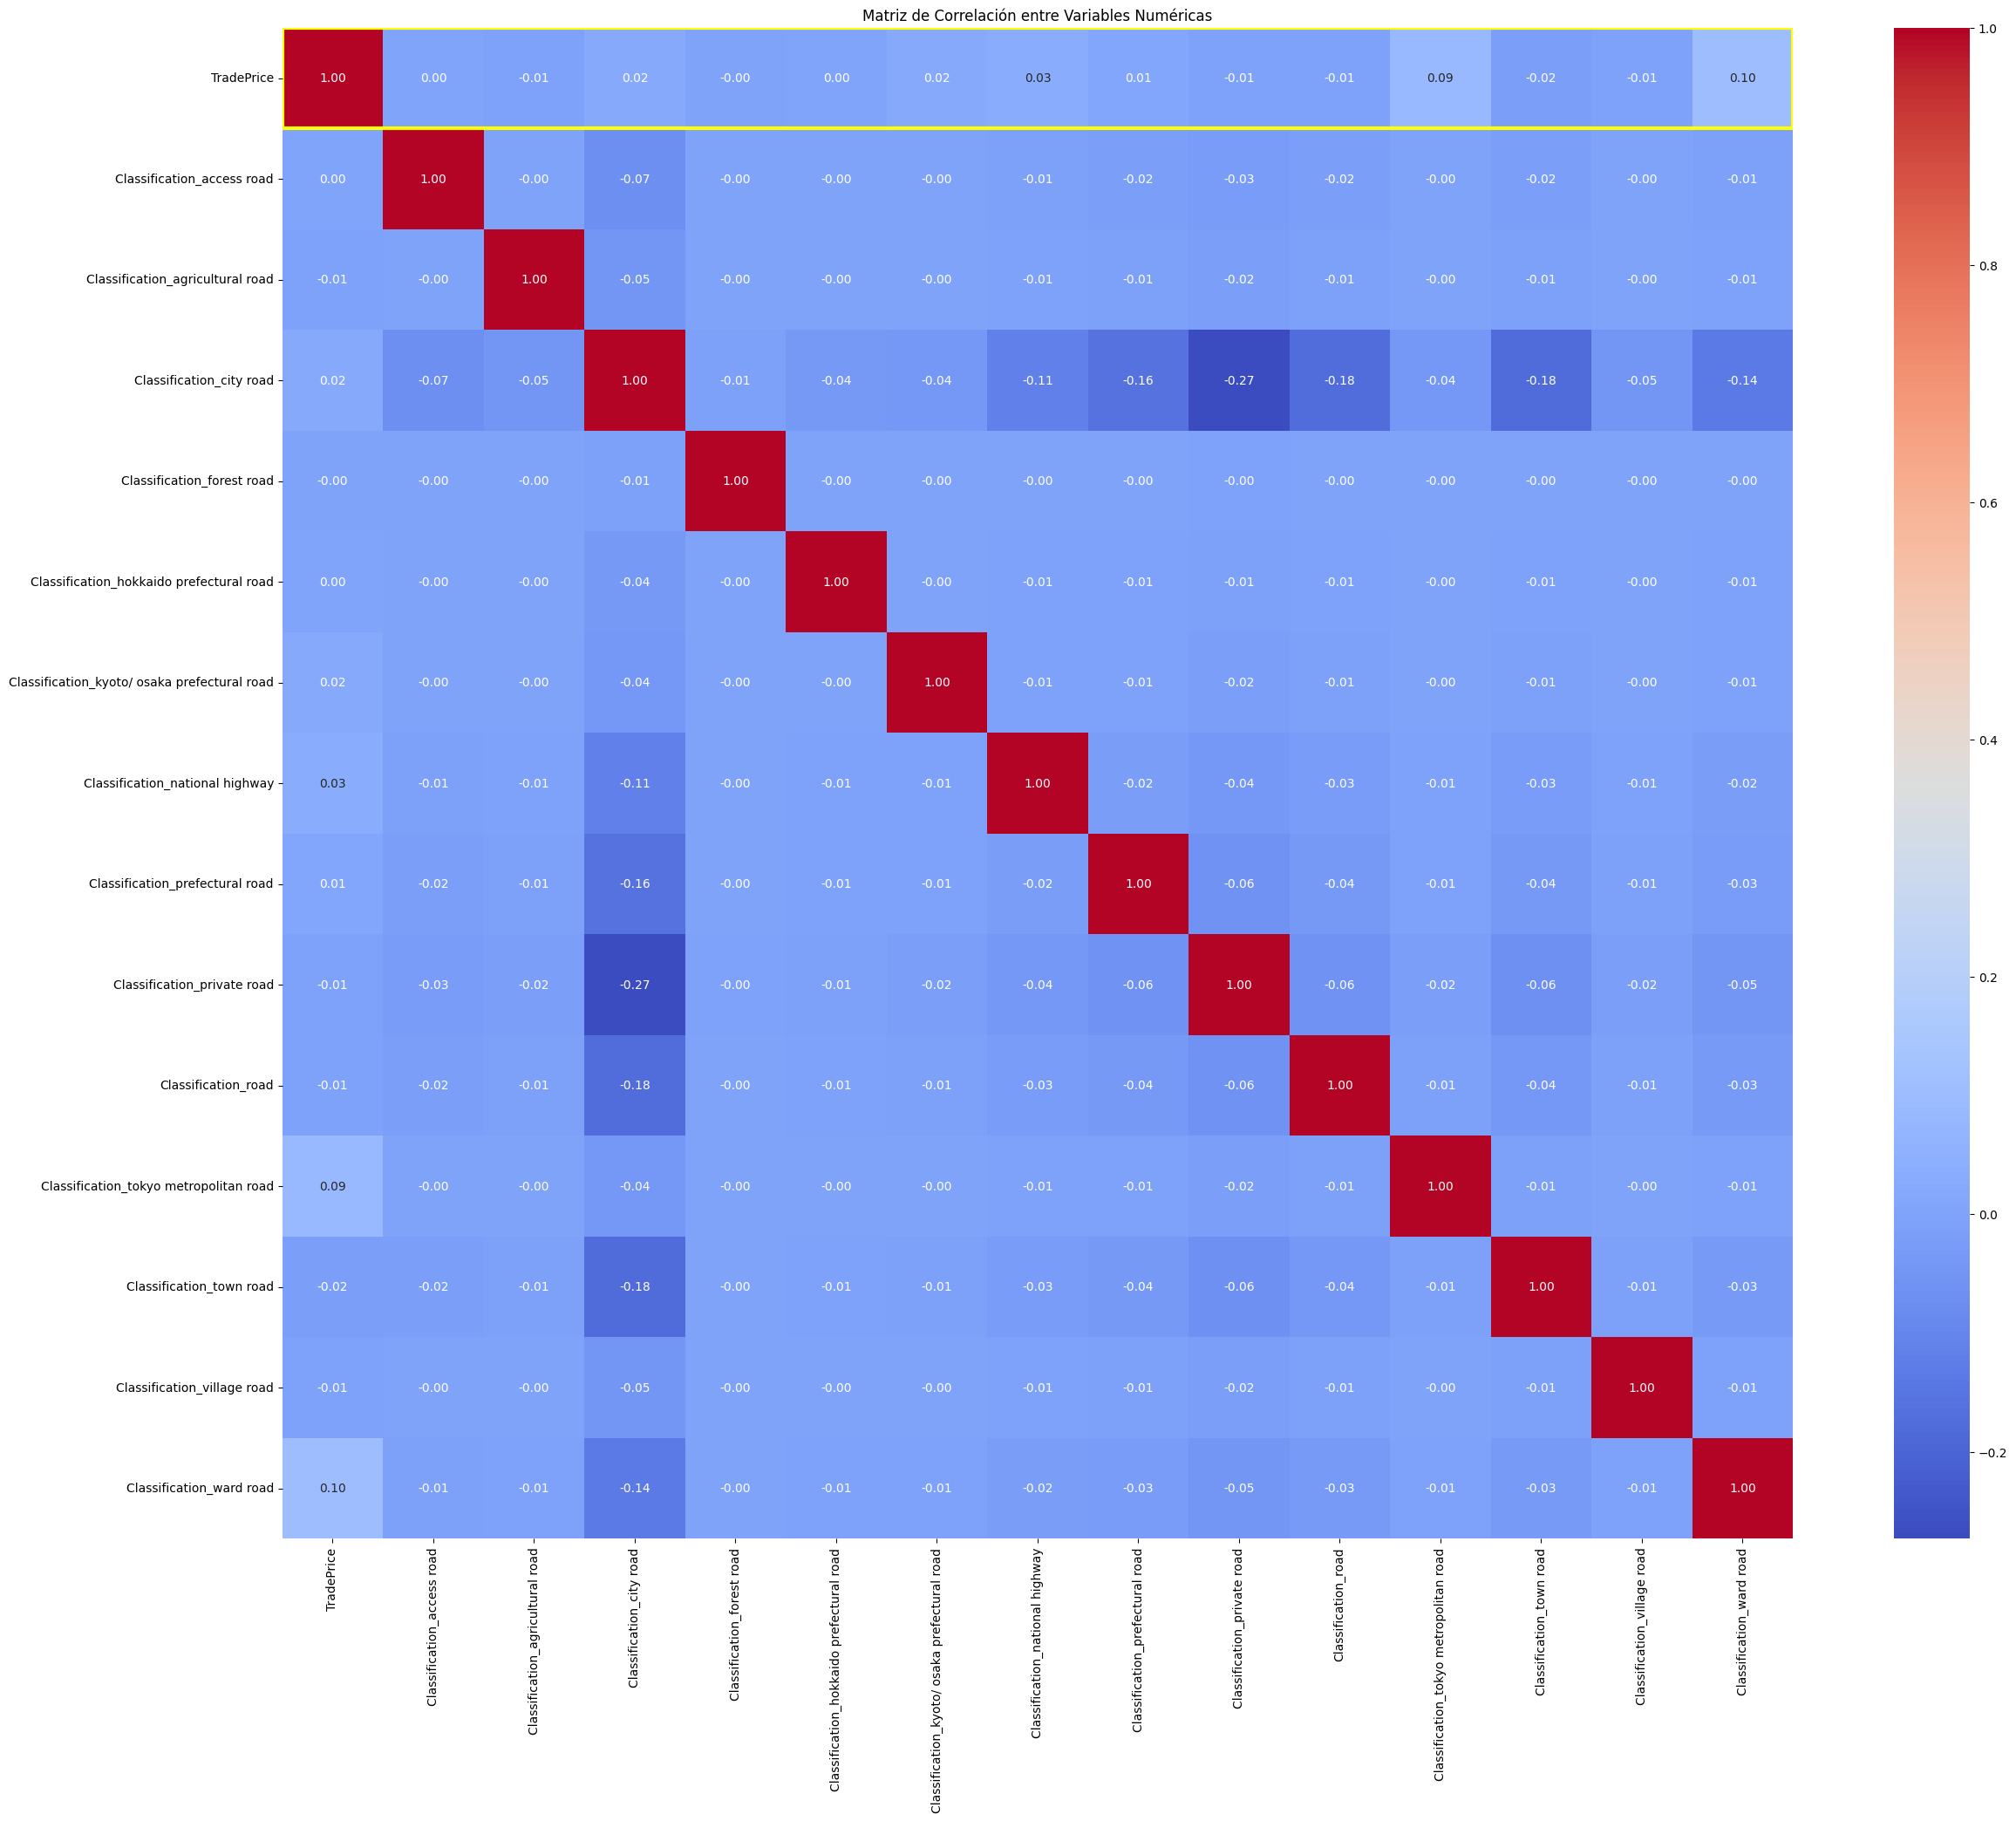


Análisis para la columna: Classification


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan

Análisis para la columna: Classification_access road
Mann-Whitney U Test:
U-statistic: 36512501451.5, P-value: 0.0

Análisis para la columna: Classification_agricultural road
Mann-Whitney U Test:
U-statistic: 29349637553.5, P-value: 0.0

Análisis para la columna: Classification_city road
Mann-Whitney U Test:
U-statistic: 2310905650773.0, P-value: 0.0

Análisis para la columna: Classification_forest road
Mann-Whitney U Test:
U-statistic: 2305487157.5, P-value: 6.645027934068381e-49

Análisis para la columna: Classification_hokkaido prefectural road
Mann-Whitney U Test:
U-statistic: 16727216730.5, P-value: 1.1016071615185626e-165

Análisis para la columna: Classification_kyoto/ osaka prefectural road
Mann-Whitney U Test:
U-statistic: 11439582732.5, P-value: 0.0

Análisis para la columna: Classification_national highway
Mann-Whitney U Test:
U-statistic: 116880547828.5, P-value: 7.328048280905198e-203

Análisis para la columna: Classif

In [87]:
df = make_dummies_analyze(df.copy(),"Classification")


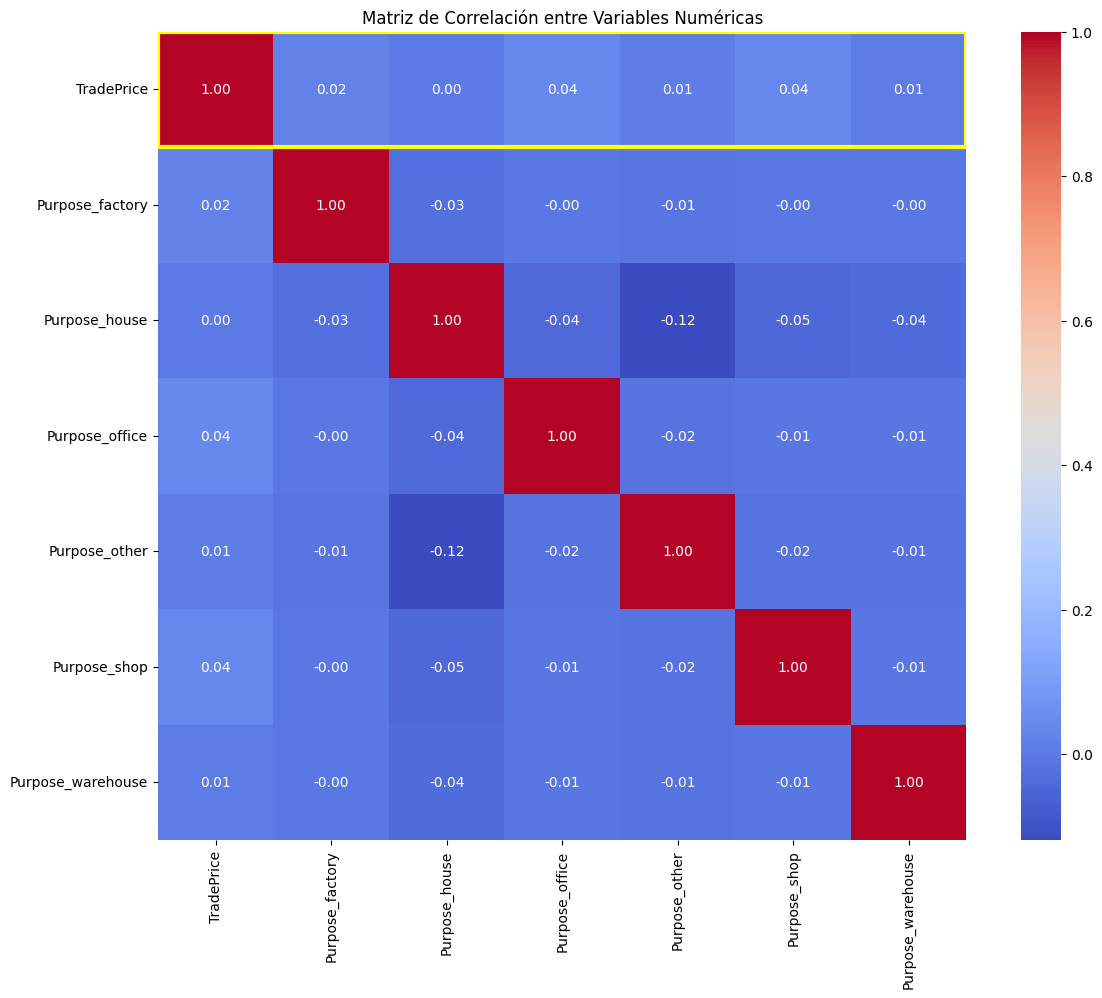


Análisis para la columna: Purpose


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan

Análisis para la columna: Purpose_factory
Mann-Whitney U Test:
U-statistic: 10840678139.5, P-value: 0.0

Análisis para la columna: Purpose_house
Mann-Whitney U Test:
U-statistic: 1019674692992.5, P-value: 0.0

Análisis para la columna: Purpose_office
Mann-Whitney U Test:
U-statistic: 33330419204.5, P-value: 0.0

Análisis para la columna: Purpose_other
Mann-Whitney U Test:
U-statistic: 267257124904.0, P-value: 0.0

Análisis para la columna: Purpose_shop
Mann-Whitney U Test:
U-statistic: 32598910341.5, P-value: 0.0

Análisis para la columna: Purpose_warehouse
Mann-Whitney U Test:
U-statistic: 37456223371.0, P-value: 1.263884037888208e-183


In [88]:
df = make_dummies_analyze(df.copy(),"Purpose")

When analyzing the linear correlation between "TradePrice" and the one-hot encoded categorical variables, it is observed that there is no significant correlation (according to the Pearson correlation coefficient) between "TradePrice" and the analyzed columns. However, the results of the Mann-Whitney U Test and Kruskal-Wallis for the different categories (Purpose_, Classification_, etc.) show significant differences in their distributions, with p-values close to zero. Although a strong linear correlation is not observed, the statistical analyses indicate that the columns significantly influence prices.


One Hot Tunned: FloorPlan, Structure, Use, Remarks, CityPlanning

FloorPlan

In [89]:
#some values have to be changed to follow the floor plan code
#duplex 2ldk
df["FloorPlan"] = df["FloorPlan"].apply(lambda x: "2ldk" if isinstance(x, str) and ("duplex" in x.lower()) else x)
#open floor y studio apartment are wrong values
# they will be replaced by 1ldk 
df["FloorPlan"] = df["FloorPlan"].apply(lambda x: "1ldk" if isinstance(x, str) and ("open floor" in x.lower() or "studio apartment" in x.lower()) else x)

In [90]:
data = {
       'FloorPlan': [
           "4ldk+s",
           "3ldk",
           "2l4dk",
           "7ldk+k",
           "8ldk+ks",
           "9ldk+k6ks", #wrong
           "10ldk+k7kd", #wrong
           "11ldk+k7kl"  #wrong
       ]
   }
df_test = pd.DataFrame(data)
df2 =  compute_floor_plan(df_test.copy()) #check the function to understand how it works
use_columns = [col for col in df2.columns if 'FloorPlan' in col]
use_df = df2[use_columns]

print(use_df.head(10))

    FloorPlan  FloorPlan_l  FloorPlan_d  FloorPlan_k  FloorPlan_s  \
0      4ldk+s            4            1            1            1   
1        3ldk            3            1            1            0   
2       2l4dk            2            4            1            0   
3      7ldk+k            7            1            1            0   
4     8ldk+ks            8            1            1            1   
5   9ldk+k6ks            9            1            6            1   
6  10ldk+k7kd           10            1            7            0   
7  11ldk+k7kl           11            1            7            0   

   FloorPlan_plus  
0               1  
1               0  
2               0  
3               1  
4               2  
5               3  
6               3  
7               3  


In [91]:
df =  compute_floor_plan(df.copy())
use_columns = [col for col in df2.columns if 'FloorPlan' in col]
use_df = df[use_columns]

print(use_df.head())

  FloorPlan  FloorPlan_l  FloorPlan_d  FloorPlan_k  FloorPlan_s  \
0       NaN            0            0            0            0   
1       NaN            0            0            0            0   
2      4ldk            4            1            1            0   
3       NaN            0            0            0            0   
4       NaN            0            0            0            0   

   FloorPlan_plus  
0               0  
1               0  
2               0  
3               0  
4               0  


In [92]:
df.head()

No                          Type            Region MunicipalityCode  \
0   1   residential land(land only)  residential area             1101   
1   2   residential land(land only)  residential area             1101   
2   3  pre-owned condominiums, etc.               NaN             1101   
3   4   residential land(land only)  residential area             1101   
4   5   residential land(land only)  residential area             1101   

  Prefecture            Municipality DistrictName NearestStation  \
0   hokkaido  chuo ward,sapporo city   asahigaoka   maruyamakoen   
1   hokkaido  chuo ward,sapporo city   asahigaoka   maruyamakoen   
2   hokkaido  chuo ward,sapporo city   asahigaoka   maruyamakoen   
3   hokkaido  chuo ward,sapporo city   asahigaoka   maruyamakoen   
4   hokkaido  chuo ward,sapporo city   asahigaoka   maruyamakoen   

  TimeToNearestStation  MinTimeToNearestStation  ...  Purpose_house  \
0                   28                     28.0  ...              0   
1                   27                     27.0  ...              1   
2                   20                     20.0  ...              1   
3                   26                     26.0  ...              0   
4                   23                     23.0  ...              1   

   Purpose_office Purpose_other  Purpose_shop  Purpose_warehouse  FloorPlan_l  \
0               0             1             0                  0            0   
1               0             0             0                  0            0   
2               0             0             0                  0            4   
3               0             0             0                  0            0   
4               0             0             0                  0            0   

   FloorPlan_d FloorPlan_k  FloorPlan_s  FloorPlan_plus  
0            0           0            0               0  
1            0           0            0               0  
2            1           1            0               0  
3            0           0            0               0  
4            0           0            0               0  

[5 rows x 97 columns]

In [93]:
to_delete.append("FloorPlan")

CityPlanning

In [94]:
one_hot_df = pd.get_dummies(df['CityPlanning'], prefix='CityPlanning', dummy_na=False,dtype=int)

# Combina el DataFrame one hot con la columna precios
combined_df = pd.concat([one_hot_df, df['TradePrice']], axis=1)

In [95]:
combined_df.head()

CityPlanning_category i exclusively low-story residential zone  \
0                                                  1                
1                                                  1                
2                                                  0                
3                                                  1                
4                                                  1                

   CityPlanning_category i exclusively medium-high residential zone  \
0                                                  0                  
1                                                  0                  
2                                                  0                  
3                                                  0                  
4                                                  0                  

   CityPlanning_category i residential zone  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   CityPlanning_category ii exclusively low-story residential zone  \
0                                                  0                 
1                                                  0                 
2                                                  0                 
3                                                  0                 
4                                                  0                 

   CityPlanning_category ii exclusively medium-high residential zone  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   CityPlanning_category ii residential zone  CityPlanning_commercial zone  \
0                                          0                             0   
1                                          0                             0   
2                                          0                             0   
3                                          0                             0   
4                                          0                             0   

   CityPlanning_exclusively industrial zone  CityPlanning_industrial zone  \
0                                         0                             0   
1                                         0                             0   
2                                         0                             0   
3                                         0                             0   
4                                         0                             0   

   CityPlanning_neighborhood commercial zone  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   

   CityPlanning_non-divided city planning area  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   CityPlanning_outside city planning area  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   CityPlanning_quasi-city planning area  CityPlanning_quasi-industrial zone  \
0                                      0                                   0   
1                                      0                         

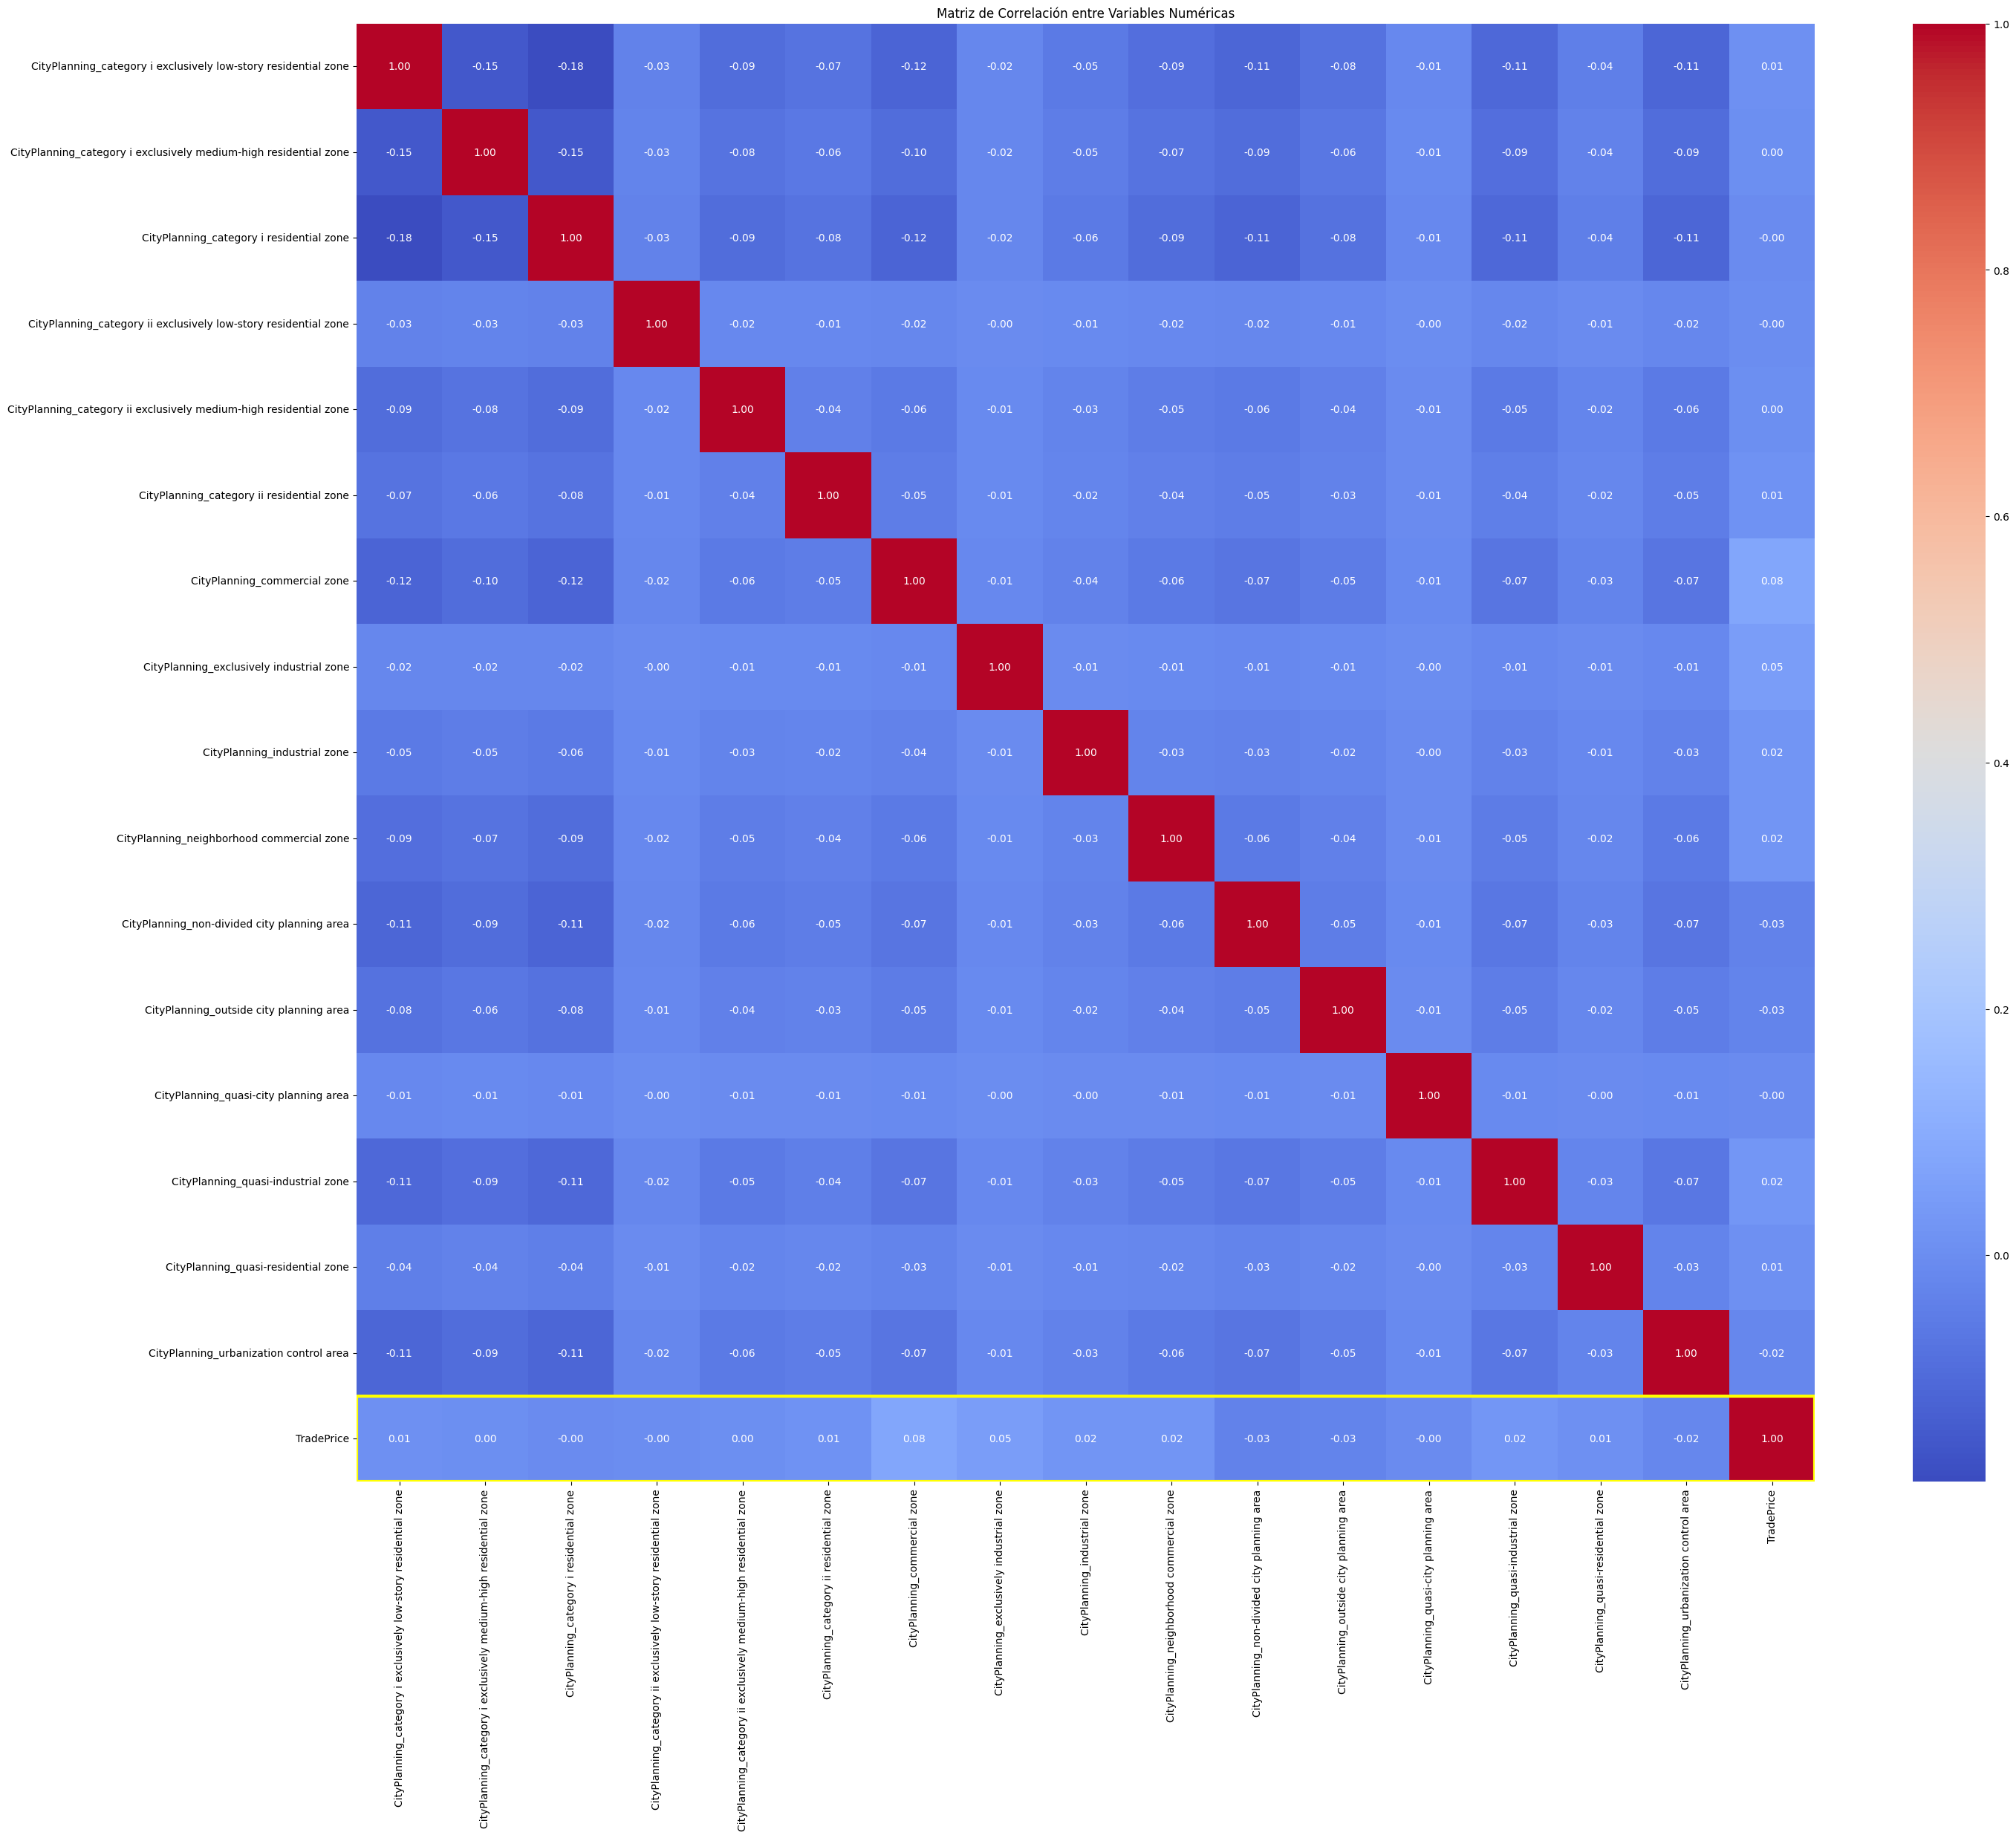

In [96]:
correlation_heatmap(combined_df.copy())

In [97]:
combined_df.corr()["TradePrice"].drop("TradePrice").abs().mean()

0.01967645087623999

In [98]:
"""------Value counts de:  CityPlanning
CityPlanning
category i residential zone                             612975
category i exclusively low-story residential zone       594252
NaN                                                     522707
category i exclusively medium-high residential zone     424012
commercial zone                                         268048
non-divided city planning area                          256053
urbanization control area                               252324
quasi-industrial zone                                   233628
category ii exclusively medium-high residential zone    174105
neighborhood commercial zone                            166561
outside city planning area                              125954
category ii residential zone                            115421
industrial zone                                          63638
quasi-residential zone                                   40008
category ii exclusively low-story residential zone       22919
exclusively industrial zone                               9846
quasi-city planning area                                  4620 """

'------Value counts de:  CityPlanning\nCityPlanning\ncategory i residential zone                             612975\ncategory i exclusively low-story residential zone       594252\nNaN                                                     522707\ncategory i exclusively medium-high residential zone     424012\ncommercial zone                                         268048\nnon-divided city planning area                          256053\nurbanization control area                               252324\nquasi-industrial zone                                   233628\ncategory ii exclusively medium-high residential zone    174105\nneighborhood commercial zone                            166561\noutside city planning area                              125954\ncategory ii residential zone                            115421\nindustrial zone                                          63638\nquasi-residential zone                                   40008\ncategory ii exclusively low-story residential zone 

In [99]:
df["CityPlanning"].head()

0    category i exclusively low-story residential zone
1    category i exclusively low-story residential zone
2                         neighborhood commercial zone
3    category i exclusively low-story residential zone
4    category i exclusively low-story residential zone
Name: CityPlanning, dtype: object

In [100]:
check_kruskal_mannwhitneyu(df.copy(),["CityPlanning"])


Análisis para la columna: CityPlanning
Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


In [101]:
mapping = {
    'category i exclusively low-story residential zone': 'low-story residential zone',
    'urbanization control area': 'urbanization control area',
    'category i residential zone': 'residential zone',
    'category i exclusively medium-high residential zone': 'medium-high residential zone',
    'category ii exclusively medium-high residential zone': 'medium-high residential zone',
    'quasi-industrial zone': 'quasi-industrial zone',
    'neighborhood commercial zone': 'neighborhood commercial zone',
    'commercial zone': 'commercial zone',
    'category ii residential zone': 'residential zone',
    'exclusively industrial zone': 'industrial zone',
    'industrial zone': 'industrial zone',
    'category ii exclusively low-story residential zone': 'low-story residential zone',
    'outside city planning area': 'outside area',
    'quasi-residential zone': 'quasi-residential zone',
    'non-divided city planning area': 'non-divided area',
    'quasi-city planning area': 'quasi-city planning area'
}

In [102]:
df_city = df[['CityPlanning']].copy()
df_city['CityPlanning'] = df_city['CityPlanning'].str.lower().replace(mapping)

In [103]:
one_hot_df = pd.get_dummies(df_city['CityPlanning'], prefix='CityPlanning', dummy_na=False,dtype=int)

# Combina el DataFrame one hot con la columna precios
combined_onehot = pd.concat([one_hot_df, df['TradePrice']], axis=1)
combined_kuscal = pd.concat([df_city, df['TradePrice']], axis=1)

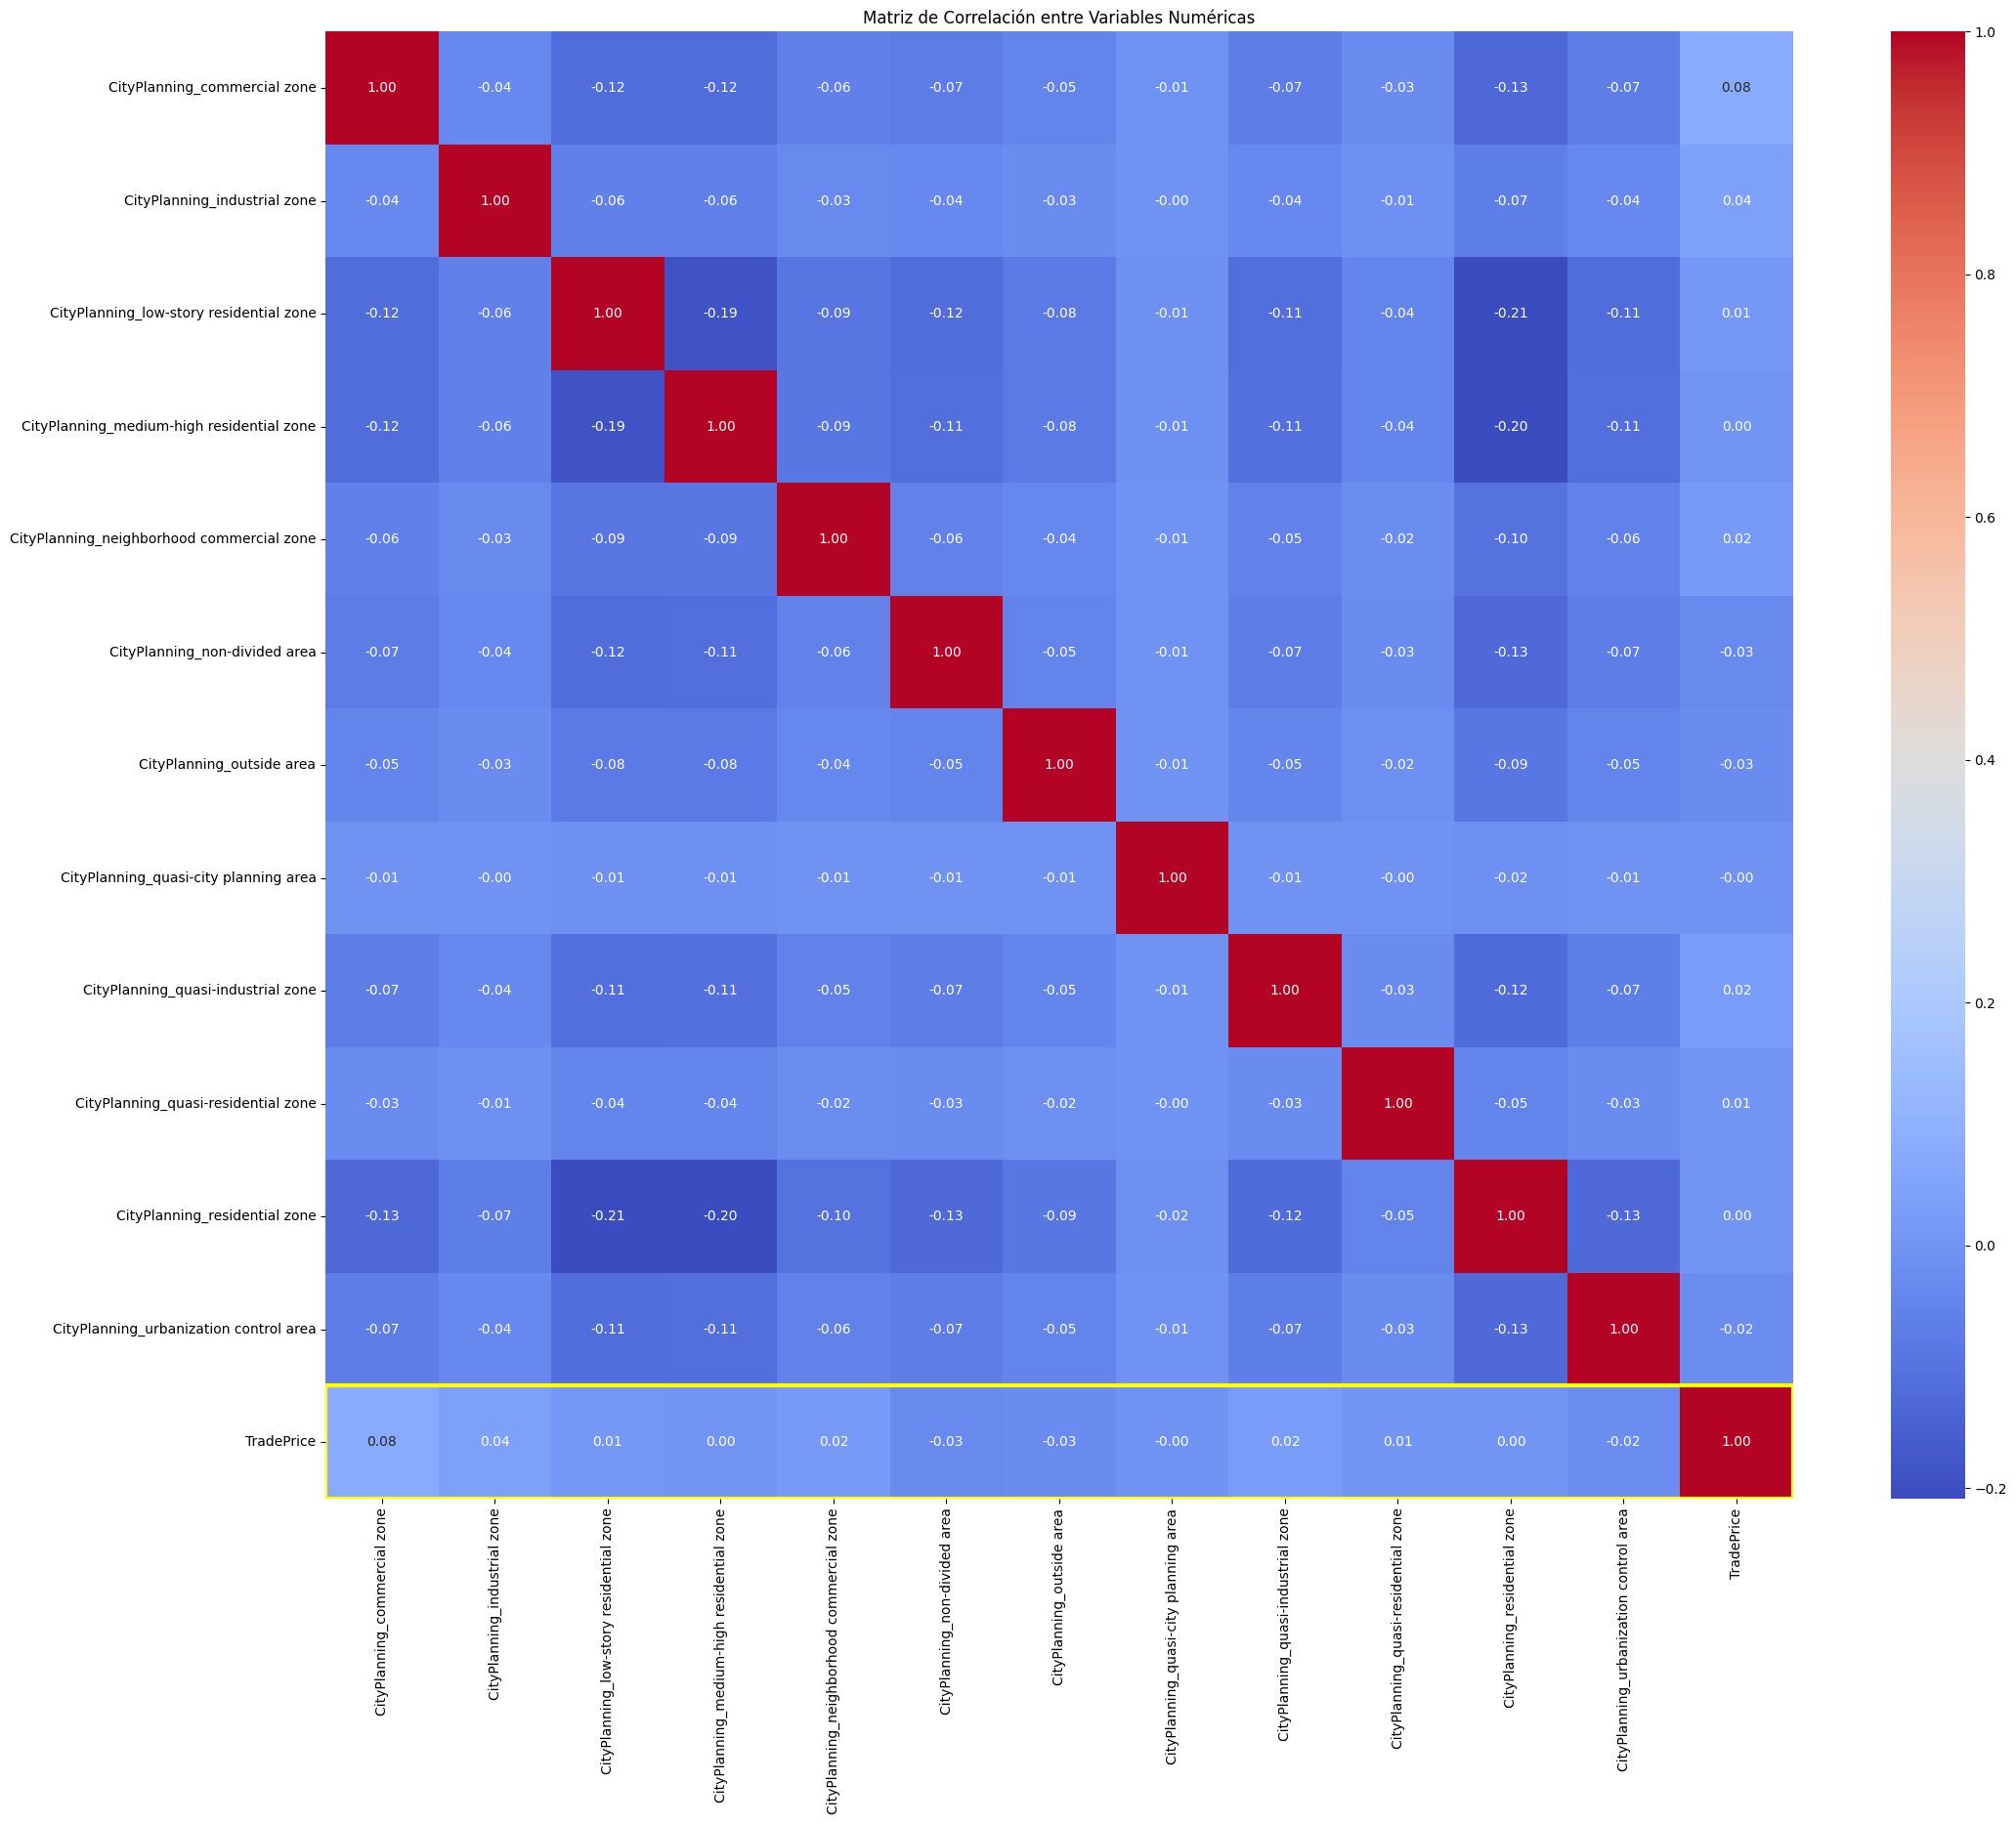

In [104]:
correlation_heatmap(combined_onehot.copy())

In [105]:
#The correlation slighly increassed 
combined_onehot.corr()["TradePrice"].drop("TradePrice").abs().mean()

0.022015699999692166

In [106]:
check_kruskal_mannwhitneyu(combined_kuscal.copy(),["CityPlanning"])


Análisis para la columna: CityPlanning
Kruskal-Wallis H Test:
H-statistic: nan, P-value: nan


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8832\4162253589.py:221: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  h_stat, p_value_kruskal = stats.kruskal(*target_groups)


The kruskal could not be applied due to size requeriments, but the transformation seems better than the original data as the correlation increassed.

In [107]:
df = pd.concat([df,one_hot_df], axis=1)

In [108]:
to_delete.append("CityPlanning")

In [109]:
df.columns

Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       ...
       'CityPlanning_low-story residential zone',
       'CityPlanning_medium-high residential zone',
       'CityPlanning_neighborhood commercial zone',
       'CityPlanning_non-divided area', 'CityPlanning_outside area',
       'CityPlanning_quasi-city planning area',
       'CityPlanning_quasi-industrial zone',
       'CityPlanning_quasi-residential zone', 'CityPlanning_residential zone',
       'CityPlanning_urbanization control area'],
      dtype='object', length=109)

USE

In [110]:
df = expand_structures_by_rank(df.copy(),"Use")

In [111]:
to_delete.append("Use")

In [112]:
use_columns = [col for col in df.columns if 'Use' in col]
use_df = df[use_columns]

print(use_df[use_df["Use"].str.contains("fac", na=False)].head())

                             Use  Use_house  Use_housing complex  Use_shop  \
51               factory, office          0                    0         0   
64               factory, office          0                    0         0   
1115      house, factory, office          1                    0         0   
1511                     factory          0                    0         0   
2788  factory, office, warehouse          0                    0         0   

      Use_office  Use_warehouse  Use_other  Use_factory  Use_parking lot  \
51             1              0          0            1                0   
64             1              0          0            1                0   
1115           1              0          0            1                0   
1511           0              0          0            1                0   
2788           1              1          0            1                0   

      Use_workshop  
51               0  
64               0  
1115       

In [113]:
df["Structure"].value_counts()

Structure
w              1031349
rc              474276
src             188843
s               126710
ls               69274
rc, w             4845
b                 3272
s, w              2675
src, rc            657
w, ls              610
rc, s              599
w, b               308
rc, b              296
src, s             168
s, b               164
s, ls              115
rc, ls              59
rc, s, w            37
src, w              35
s, w, b             29
rc, w, b            27
s, w, ls            23
b, ls               22
rc, w, ls           13
w, b, ls             9
rc, s, ls            7
src, b               6
s, b, ls             4
rc, b, ls            4
rc, s, b             3
src, rc, s           2
src, w, b            1
rc, s, w, b          1
s, rc, w             1
src, ls              1
Name: count, dtype: int64

In [114]:
df = expand_structures(df.copy(),"Structure")
df = expand_structures(df.copy(),"Remarks")

to_delete.append("Structure")
to_delete.append("Remarks")

In [115]:
df.columns

Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       ...
       'Structure_ls', 'Structure_b',
       'Remarks_dealings including private road',
       'Remarks_dealings in which auction or arbiter participates',
       'Remarks_dealings of adjacent land',
       'Remarks_dealings between related objects',
       'Remarks_dealings including special circumstances',
       'Remarks_dealings including valueless house',
       'Remarks_dealings of real estate that includes wound etc.',
       'Remarks_dealings of real estate to which mortgage etc. are set'],
      dtype='object', length=132)

In [116]:
structure_columns = [col for col in df.columns if 'Structure' in col]

# Mostrar las columnas que contienen "Structure"
print(df[structure_columns])


        Structure  Structure_w  Structure_rc  Structure_src  Structure_s  \
0                            0             0              0            0   
1                            0             0              0            0   
2              rc            0             1              0            0   
3                            0             0              0            0   
4                            0             0              0            0   
...           ...          ...           ...            ...          ...   
3906513                      0             0              0            0   
3906514                      0             0              0            0   
3906515                      0             0              0            0   
3906516                      0             0              0            0   
3906517                      0             0              0            0   

         Structure_ls  Structure_b  
0                   0            0  
1            

In [117]:
structure_columns = [col for col in df.columns if 'Remarks' in col]

# Mostrar las columnas que contienen "Structure"
print(df[structure_columns])

        Remarks  Remarks_dealings including private road  \
0                                                      0   
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      0   
...         ...                                      ...   
3906513                                                0   
3906514                                                0   
3906515                                                0   
3906516                                                0   
3906517                                                0   

         Remarks_dealings in which auction or arbiter participates  \
0                                                        0           
1                                                        0           
2                                                        0           

In [118]:
df.columns.tolist()

['No',
 'Type',
 'Region',
 'MunicipalityCode',
 'Prefecture',
 'Municipality',
 'DistrictName',
 'NearestStation',
 'TimeToNearestStation',
 'MinTimeToNearestStation',
 'MaxTimeToNearestStation',
 'TradePrice',
 'FloorPlan',
 'Area',
 'AreaIsGreaterFlag',
 'UnitPrice',
 'PricePerTsubo',
 'LandShape',
 'Frontage',
 'FrontageIsGreaterFlag',
 'TotalFloorArea',
 'TotalFloorAreaIsGreaterFlag',
 'BuildingYear',
 'PrewarBuilding',
 'Structure',
 'Use',
 'Purpose',
 'Direction',
 'Classification',
 'Breadth',
 'CityPlanning',
 'CoverageRatio',
 'FloorAreaRatio',
 'Period',
 'Year',
 'Quarter',
 'Renovation',
 'Remarks',
 'Perfect_Price',
 'MaxBaseCoverage',
 'MaxTotalArea',
 'MaxPerfectPrice',
 'CoveragePerfectPrice',
 'Renovation_done',
 'Renovation_not yet',
 'Region_commercial area',
 'Region_industrial area',
 'Region_potential residential area',
 'Region_residential area',
 'Type_agricultural land',
 'Type_forest land',
 'Type_pre-owned condominiums, etc.',
 'Type_residential land(land a

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3887071 entries, 0 to 3906517
Columns: 132 entries, No to Remarks_dealings of real estate to which mortgage etc. are set
dtypes: bool(4), float64(14), int32(62), int64(33), object(19)
memory usage: 2.9+ GB


In [120]:
to_delete

['No',
 'TimeToNearestStation',
 'Period',
 'PricePerTsubo',
 'Type',
 'LandShape',
 'Direction',
 'Classification',
 'Purpose',
 'Region',
 'Renovation',
 'FloorPlan',
 'CityPlanning',
 'Use',
 'Structure',
 'Remarks']

In [121]:
df = df.drop(columns=to_delete)

In [122]:
df.to_csv('EDA-Fase2.csv', index=False, header=True)